In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import prange
from joint_QR import *

Define grid points 
- Two sets i=1,2
- 100 points from 0.01 - 1 (for quantiles tau)

In [2]:
sub_ids = np.array(100*[0] + 100*[1]).reshape(-1,1)
grid_vals = np.concatenate([np.arange(0.01,1.01,0.01),
                            np.arange(0.01,1.01,0.01)]).reshape(-1,1)

gp_inputs = np.hstack([sub_ids, grid_vals])

In [3]:
cov_mat = covariance_mat_single_var(gp_inputs,
                         kappa=0.5,
                         rho=1,
                         lambd=10)

mean_vec = np.zeros(len(gp_inputs))

Sample some paths from the GP

In [4]:
n_samples = 50
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])
c_samples = np.exp(w_samples)

Plot

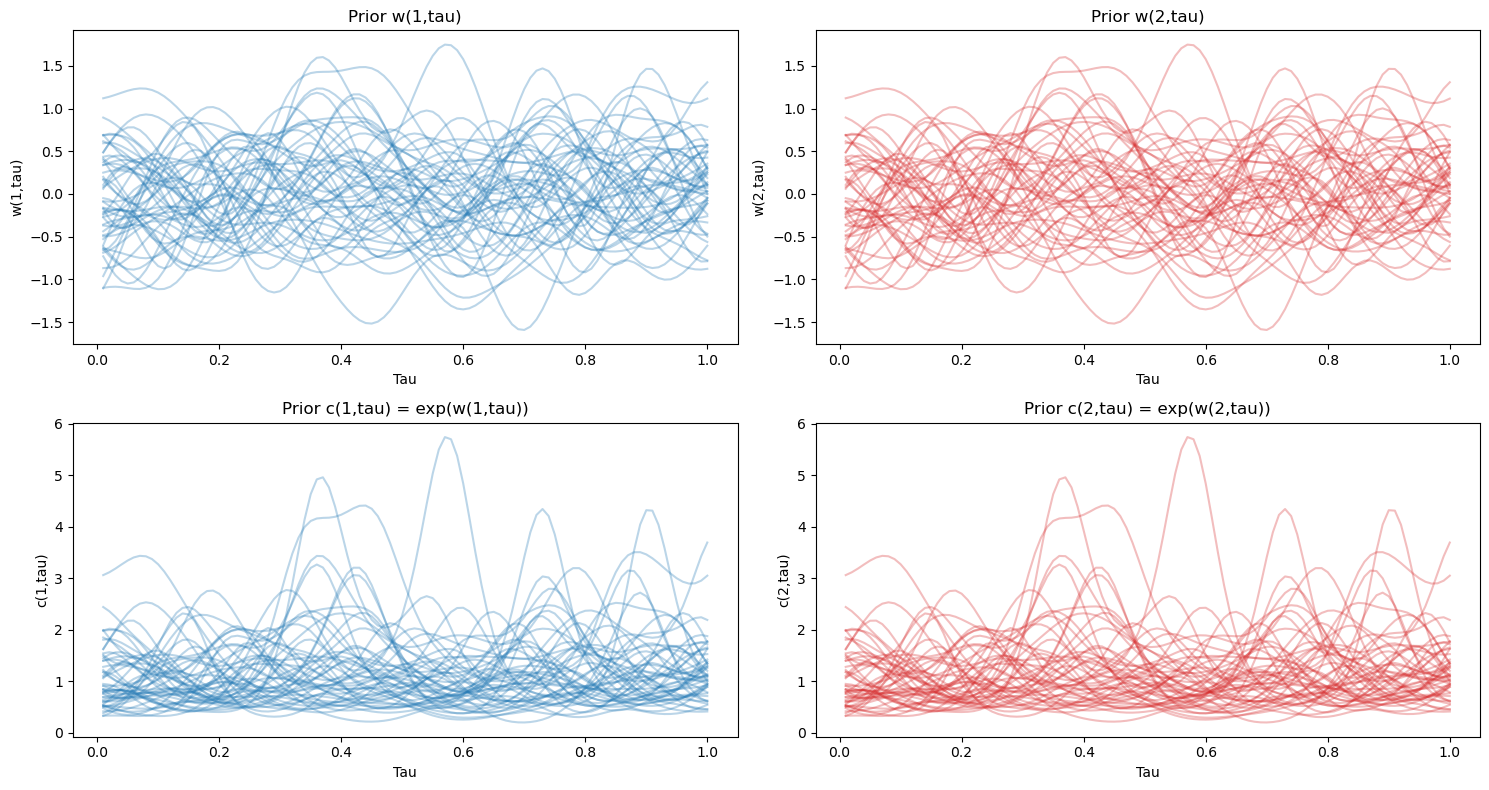

In [5]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

taus = tau_grid = np.arange(0.01,1.01,0.01)
tau_range = np.hstack([tau_grid.reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, w_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[0,1].plot(tau_range[:,0:100].T, w_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('w(1,tau)')
ax[0,1].set_ylabel('w(2,tau)')


ax[0,0].set_title('Prior w(1,tau)')
ax[0,1].set_title('Prior w(2,tau)')

# After exponential transform
ax[1,0].plot(tau_range[:,0:100].T, c_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[1,1].plot(tau_range[:,0:100].T, c_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('c(1,tau)')
ax[1,1].set_ylabel('c(2,tau)')


ax[1,0].set_title('Prior c(1,tau) = exp(w(1,tau))')
ax[1,1].set_title('Prior c(2,tau) = exp(w(2,tau))')

plt.tight_layout()
plt.show()

# Logistic Transform

Trapezoidal Rule

In [6]:
from typing import Union

In [7]:
@numba.njit
def calc_grid_trapezoidal(tau_grid: np.ndarray,
                          c_vals:np.ndarray,
                          last_id: Union[int, np.ndarray]) -> float:    

    
    trapz_len = tau_grid[1] - tau_grid[0]
    trapz_sum = (trapz_len/2)*(c_vals[0] + 2*c_vals[1:last_id].sum() + c_vals[last_id])
    
    return trapz_sum

@numba.njit
def calculate_contiguous_row_sums_numba(in_matrix,
                                        start_column_indices,
                                        end_column_indices):
    row_sums = np.zeros(len(in_matrix))
    
    for i in prange(len(in_matrix)):
        start = start_column_indices[i]
        end = end_column_indices[i]
        row_sums[i] = sum(in_matrix[i, start:end])
    
    return row_sums

@numba.njit
def calc_grid_trapezoidal_vector(tau_grid,
                                  c_vals,
                                  c_samp_repeat,
                                 last_ids):
    
    #print('as')

    trapz_len = tau_grid[1] - tau_grid[0]

    #c_samp_repeat = np.repeat(c_vals[:,np.newaxis],len(tau_grid), axis=1).T
    
    
    mid_vals = calculate_contiguous_row_sums_numba(c_samp_repeat,
                                                   np.ones(len(last_ids), dtype='int'),
                                                   last_ids)

    trapz_sum = (trapz_len/2)*(c_vals[0] + 2*mid_vals + c_vals[last_ids])
    return trapz_sum
    
@numba.njit
def get_interval_vector(tau_in: Union[float, np.ndarray],
                 taus: np.ndarray) -> np.ndarray:
    
    #tau_max = len(taus)
    #out_mat = np.empty_like(tau_in,dtype='int')
    trapz_len = taus[1] - taus[0]
    out_mat = np.ceil((tau_in - taus[0]) / trapz_len)
    out_mat = out_mat.astype(np.int32)
    
    return out_mat

@numba.njit
def get_interval(tau_in: Union[float, np.ndarray],
                 taus: np.ndarray) -> np.ndarray:
    
    #tau_max = len(taus)
    #out_mat = np.empty_like(tau_in,dtype='int')
    trapz_len = taus[1] - taus[0]
    out_mat = np.ceil((tau_in - taus[0]) / trapz_len)
    
    return int(out_mat)

In [74]:
def logistic_transform(tau_input: Union[float, np.ndarray],
                       tau_grid: np.ndarray,
                       c_vals_i: np.ndarray):
    
    # Calc grid distance
    trapz_len = tau_grid[1] - tau_grid[0]
    
    # Calc normalizing constant
    norm_const = calc_grid_trapezoidal(tau_grid,
                                       c_vals_i,
                                       len(tau_grid)-1)
    
    # Get position where tau input falls on grid
    t_l = get_interval(tau_input, tau_grid)
    
    if hasattr(tau_input, "__len__"):
        t_l = t_l.astype('int')
    else:
        t_l = int(t_l)
        
    t_l_1 = t_l-1


    #e_i
    e_t_l = calc_grid_trapezoidal(tau_grid, c_vals_i, t_l) / norm_const
    e_t_l_1 = calc_grid_trapezoidal(tau_grid, c_vals_i, t_l_1) / norm_const

    e_tau_hat = (e_t_l*(tau_input - tau_grid[t_l_1]) + \
                e_t_l_1*(tau_grid[t_l]-tau_input) - \
                (tau_input-tau_grid[t_l_1])*(tau_grid[t_l]-tau_input)*(c_vals_i[t_l]-c_vals_i[t_l_1])) / \
                (tau_grid[t_l] - tau_grid[t_l_1])
    
    return e_tau_hat

@numba.njit
def logistic_transform_vector(tau_input: Union[float, np.ndarray],
                       tau_grid: np.ndarray,
                       c_vals_i: np.ndarray):
    
    # Calc grid distance
    trapz_len = tau_grid[1] - tau_grid[0]
    
    # Calc normalizing constant
    norm_const = calc_grid_trapezoidal(tau_grid,
                                       c_vals_i,
                                       len(tau_grid)-1)
    
    # Get position where tau input falls on grid
    t_ls = get_interval_vector(tau_input, tau_grid).astype('int')
    t_ls_1 = t_ls-1
    
    """
    if hasattr(tau_input, "__len__"):
        t_ls = t_ls.astype('int')
    else:
        t_ls = int(t_ls)
    
    t_ls_1 = t_ls-1
    """

    #e_i
    #c_samp_repeat = np.repeat(c_vals_i[:,np.newaxis],len(tau_input), axis=1).T
    c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                    len(tau_input))).T
    
    e_t_l = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls) / norm_const
    e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls_1) / norm_const

    e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
                e_t_l_1*(tau_grid[t_ls]-tau_input) - \
                (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(c_vals_i[t_ls]-c_vals_i[t_ls_1])) / \
                (tau_grid[t_ls] - tau_grid[t_ls_1])
    
    return e_tau_hat


In [117]:
n_samples = 50
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])
c_samples = np.exp(w_samples)

c_samples_1 = c_samples[:,0:len(taus)]
c_samples_2 = c_samples[:,len(taus):]

In [122]:
%%timeit
e_samples_1 = np.array([logistic_transform_vector(taus, taus, c_samples_1[s,:])
                        for s in range(n_samples)])

e_samples_2 = np.array([logistic_transform_vector(taus, taus, c_samples_2[s,:])
                        for s in range(n_samples)])


1.02 ms ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [119]:
#%%timeit
e_samples_1_old = np.array([[logistic_transform(t, taus, c_samples_1[s,:]) for t in taus]
                        for s in range(n_samples)])

e_samples_2_old = np.array([[logistic_transform(t, taus, c_samples_2[s,:]) for t in taus]
                        for s in range(n_samples)])

In [121]:
np.all(e_samples_1 == e_samples_1_old)

True

Original
- 62.2 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
New 
- 1.02 ms ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

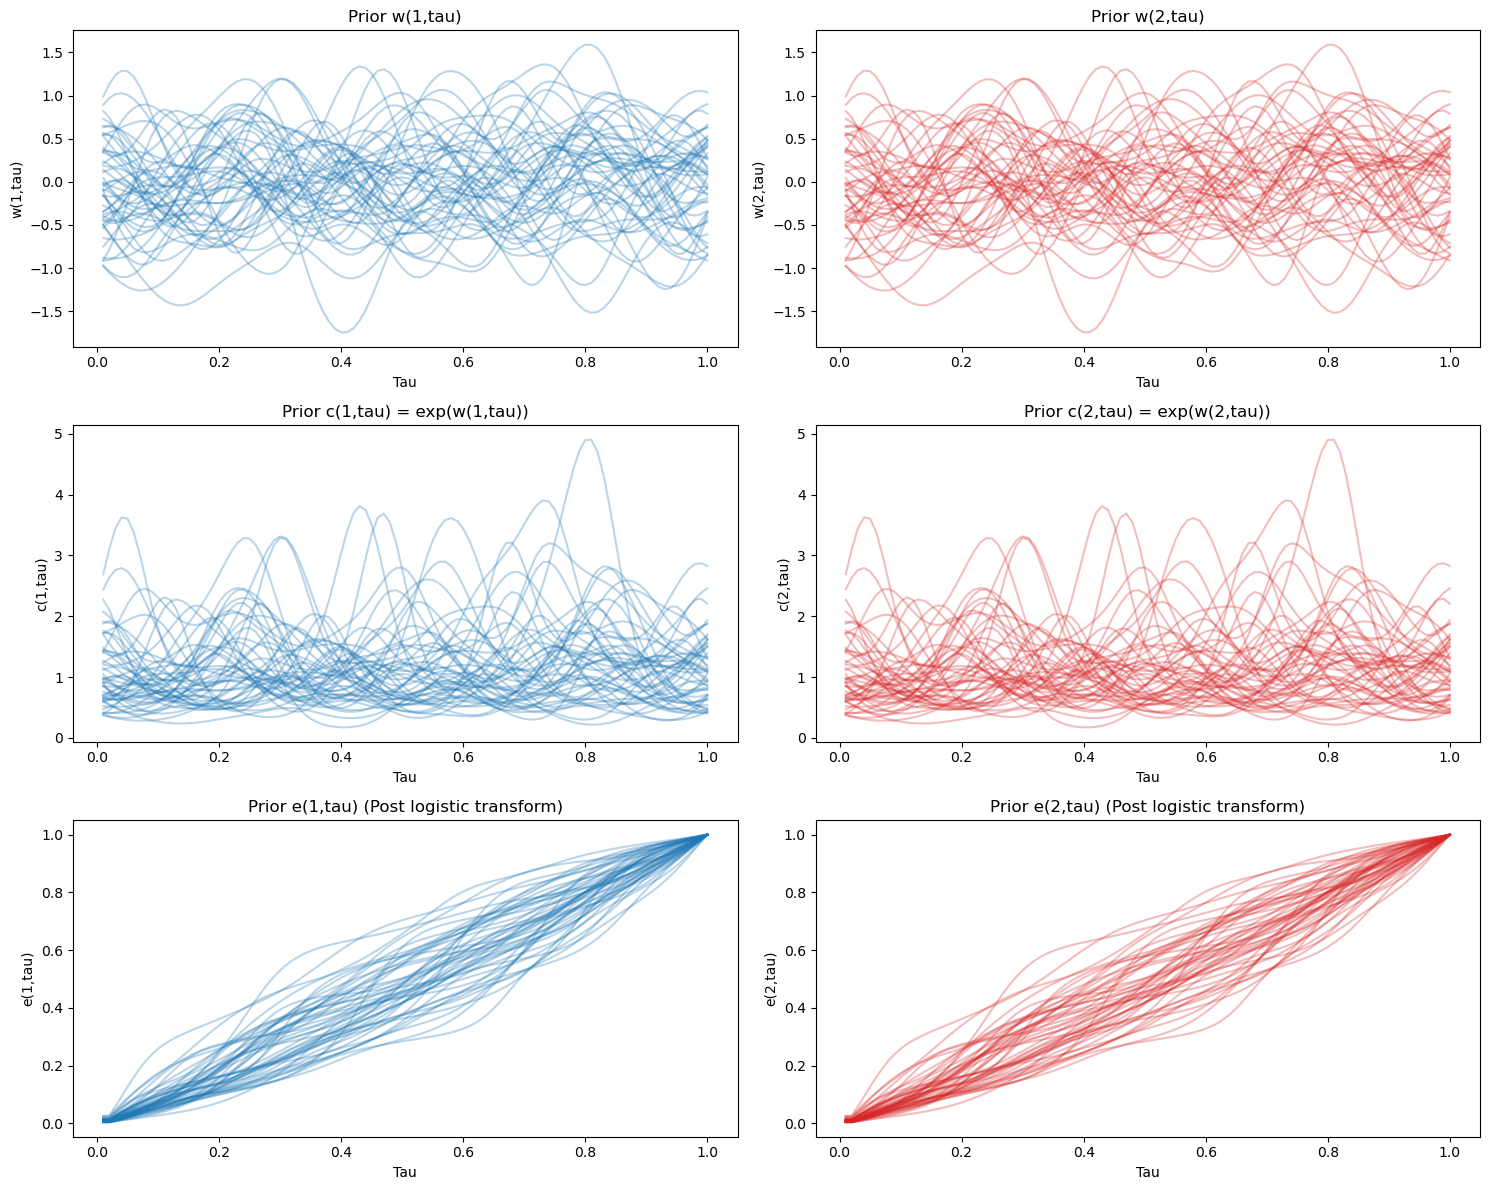

In [78]:
fig, ax = plt.subplots(3,2, figsize=(15,12))

tau_range = np.hstack([np.arange(0.01,1.01,0.01).reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, w_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[0,1].plot(tau_range[:,0:100].T, w_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('w(1,tau)')
ax[0,1].set_ylabel('w(2,tau)')


ax[0,0].set_title('Prior w(1,tau)')
ax[0,1].set_title('Prior w(2,tau)')

# After exponential transform
ax[1,0].plot(tau_range[:,0:100].T, c_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[1,1].plot(tau_range[:,0:100].T, c_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('c(1,tau)')
ax[1,1].set_ylabel('c(2,tau)')


ax[1,0].set_title('Prior c(1,tau) = exp(w(1,tau))')
ax[1,1].set_title('Prior c(2,tau) = exp(w(2,tau))')


# After logistic transform
ax[2,0].plot(tau_range[:,0:100].T, e_samples_1.T, c='tab:blue', alpha=0.3)
ax[2,1].plot(tau_range[:,0:100].T, e_samples_2.T, c='tab:red', alpha=0.3)

ax[2,0].set_xlabel('Tau')
ax[2,1].set_xlabel('Tau')

ax[2,0].set_ylabel('e(1,tau)')
ax[2,1].set_ylabel('e(2,tau)')


ax[2,0].set_title('Prior e(1,tau) (Post logistic transform)')
ax[2,1].set_title('Prior e(2,tau) (Post logistic transform)')

plt.tight_layout()
plt.show()

# Calculating eta

In [162]:
base_quantile_function_numba(0.5, 1.0, 2.0,1,'norm')

array(1.)

In [198]:
from scipy.stats import norm
from numba_stats import norm as numba_norm
from numba_stats import t as numba_t

def base_quantile_function(tau: float,
                      mean: float,
                      sd: float,
                      v: int=1,
                      dist: str='norm'):
    
    if dist=='norm':
        return norm.ppf(tau, mean, sd)
    
    elif dist == 't':
        return t.ppf(tau, df=v, loc=mean, scale=sd)
    
    else:
        print('Error')
        
def base_quantile_function_numba(tau: float,
                      mean: float,
                      sd: float,
                      v: int=1,
                      dist: str='norm'):
    
    if dist=='norm':
        return numba_norm.ppf(tau, mean, sd)
    
    elif dist == 't':
        return numba_t.ppf(tau, df=v, loc=mean, scale=sd)
    
    else:
        print('Error')
        
def eta_function_i(tau_input: np.ndarray,
                 w_vals: np.ndarray,
                 tau_grid: np.ndarray,
                 mean: float,
                 sd: float,
                 v: int,
                 sigma: float,
                 dist: str='norm'):
    
    
    c_vals = np.exp(w_vals)

    
    # Apply logistic transform
    if len(c_vals.shape) > 1:
        
        # if tau_input is a vector
        if hasattr(tau_input, "__len__"):
            xi_vals = np.array([logistic_transform_vector(tau_input, tau_grid, c_vals[s,:])
                                for s in range(c_vals.shape[0])])
        else:
            xi_vals = np.array([logistic_transform(tau_input, tau_grid, c_vals[s,:]) for s in range(c_vals.shape[0])])
            
    else:
        if hasattr(tau_input, "__len__"):
            xi_vals = np.array(logistic_transform_vector(tau_input, tau_grid, c_vals))
        else:
            xi_vals = logistic_transform(tau_input, tau_grid, c_vals)
    
    # Apply 
    eta_out = sigma * base_quantile_function(xi_vals,
                                                 mean,
                                                 sd,
                                                 dist=dist)
    
    return eta_out

@numba.njit
def eta_function_i_vector(tau_input: np.ndarray,
                 w_vals: np.ndarray,
                 tau_grid: np.ndarray,
                 mean: float,
                 sd: float,
                 v: int,
                 sigma: float,
                 dist: str='norm'):
    
    
    c_vals = np.exp(w_vals)
    
    # Apply logistic transform

    xi_vals = logistic_transform_vector(tau_input, tau_grid, c_vals)

    # Apply 

    if dist == 'norm':
        eta_out = sigma * numba_norm.ppf(xi_vals,
                                     mean,
                                     sd)
    
    
    return eta_out


In [199]:
n_samples = 50

# Base guassian process - w
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])

# zeta samples
c_samples = np.exp(w_samples)
c_samples_1 = c_samples[:,0:len(taus)]
c_samples_2 = c_samples[:,len(taus):]

# xi samples
e_samples_1 = np.array([logistic_transform_vector(taus, taus, c_samples_1[s,:])
                        for s in range(n_samples)])

e_samples_2 = np.array([logistic_transform_vector(taus, taus, c_samples_2[s,:])
                        for s in range(n_samples)])

# eta samples
sigma_1 = 0.5
sigma_2 = 0.5
mu_0 = 0
sigma_0 = 1

eta_samples_1 = sigma_1 * base_quantile_function(e_samples_1[:,:-1],
                                                 mu_0,
                                                 sigma_0,
                                                 dist='norm')

eta_samples_2 = sigma_2 * base_quantile_function(e_samples_2[:,:-1],
                                                 mu_0,
                                                 sigma_0,
                                                 dist='norm')

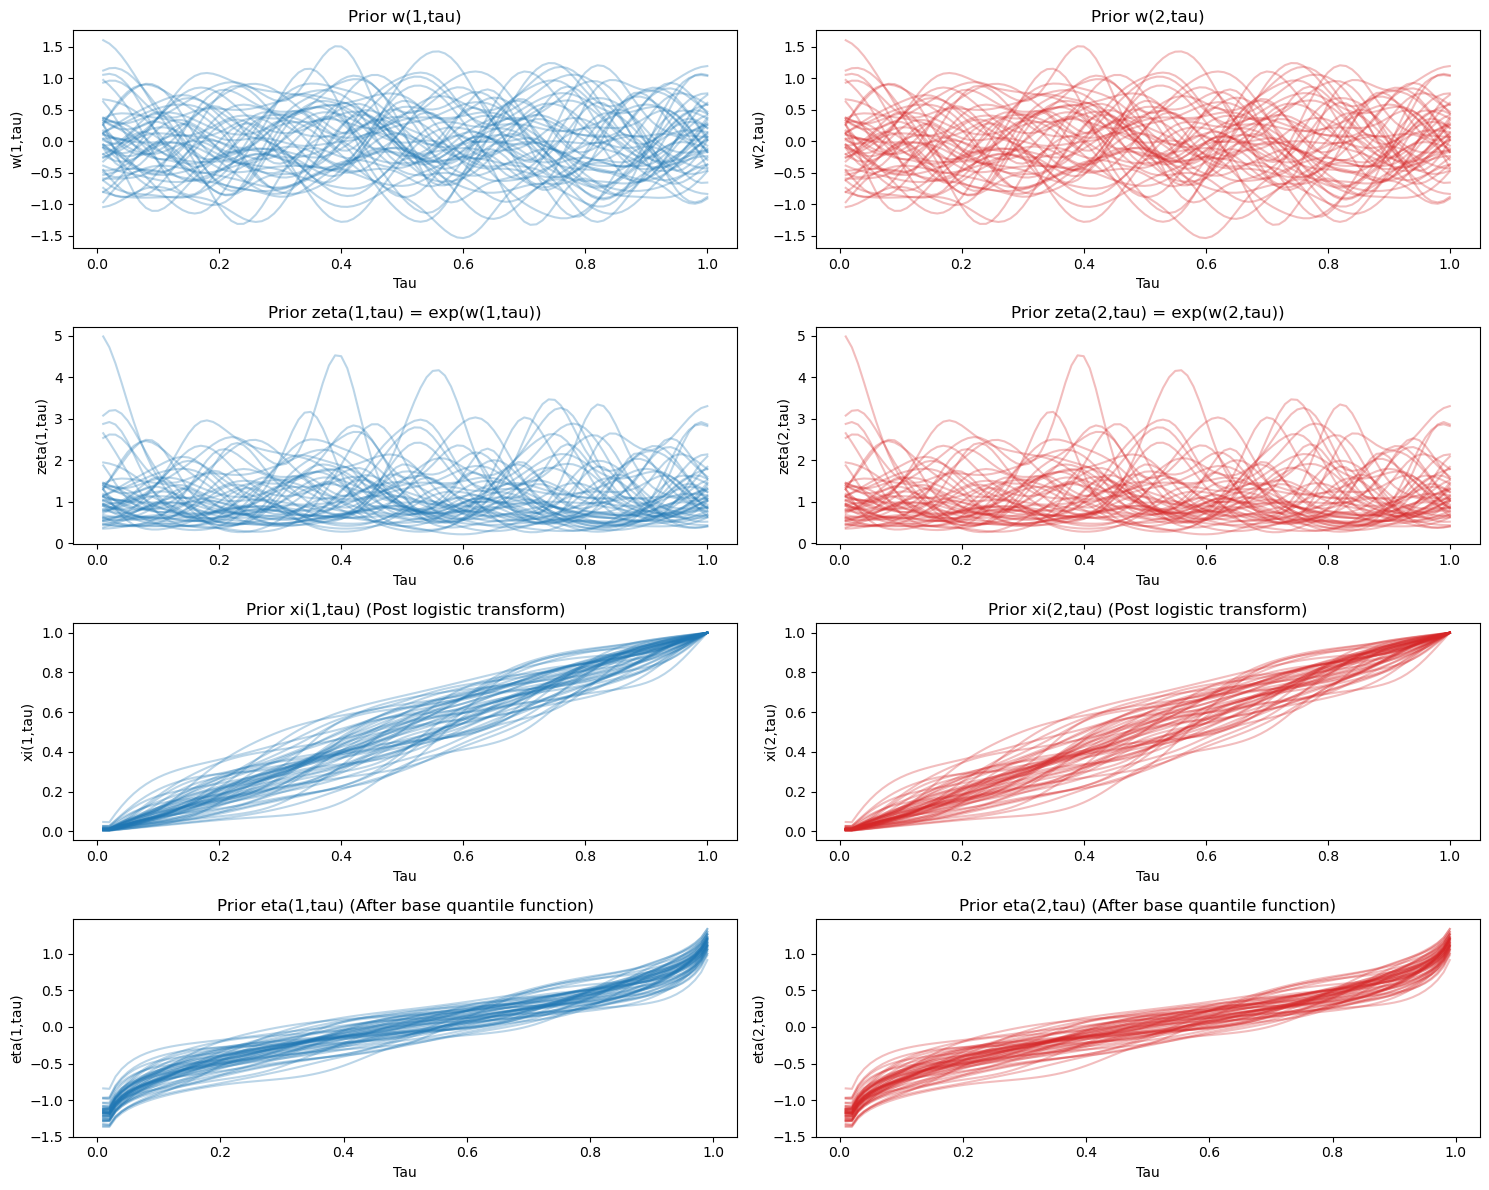

In [200]:
fig, ax = plt.subplots(4,2, figsize=(15,12))

tau_range = np.hstack([np.arange(0.01,1.01,0.01).reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, w_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[0,1].plot(tau_range[:,0:100].T, w_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('w(1,tau)')
ax[0,1].set_ylabel('w(2,tau)')


ax[0,0].set_title('Prior w(1,tau)')
ax[0,1].set_title('Prior w(2,tau)')

# After exponential transform
ax[1,0].plot(tau_range[:,0:100].T, c_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[1,1].plot(tau_range[:,0:100].T, c_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('zeta(1,tau)')
ax[1,1].set_ylabel('zeta(2,tau)')


ax[1,0].set_title('Prior zeta(1,tau) = exp(w(1,tau))')
ax[1,1].set_title('Prior zeta(2,tau) = exp(w(2,tau))')


# After logistic transform
ax[2,0].plot(tau_range[:,0:100].T, e_samples_1.T, c='tab:blue', alpha=0.3)
ax[2,1].plot(tau_range[:,0:100].T, e_samples_2.T, c='tab:red', alpha=0.3)

ax[2,0].set_xlabel('Tau')
ax[2,1].set_xlabel('Tau')

ax[2,0].set_ylabel('xi(1,tau)')
ax[2,1].set_ylabel('xi(2,tau)')


ax[2,0].set_title('Prior xi(1,tau) (Post logistic transform)')
ax[2,1].set_title('Prior xi(2,tau) (Post logistic transform)')


# After base quantile function
ax[3,0].plot(tau_range[:,0:99].T, eta_samples_1.T, c='tab:blue', alpha=0.3)
ax[3,1].plot(tau_range[:,0:99].T, eta_samples_2.T, c='tab:red', alpha=0.3)

ax[3,0].set_xlabel('Tau')
ax[3,1].set_xlabel('Tau')

ax[3,0].set_ylabel('eta(1,tau)')
ax[3,1].set_ylabel('eta(2,tau)')


ax[3,0].set_title('Prior eta(1,tau) (After base quantile function)')
ax[3,1].set_title('Prior eta(2,tau) (After base quantile function)')

plt.tight_layout()
plt.show()

In [201]:
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])

eta_samples_1 = np.array([eta_function_i_vector(tau_grid[:-1], w_samples[s,0:100],
                         tau_grid, 0.0,1.0,1,0.5,'norm') for s in range(n_samples)])

eta_samples_2 = np.array([eta_function_i(tau_grid[:-1], w_samples[s,100:200],
                         tau_grid, 0.0,1.0,1,0.5,'norm') for s in range(n_samples)])

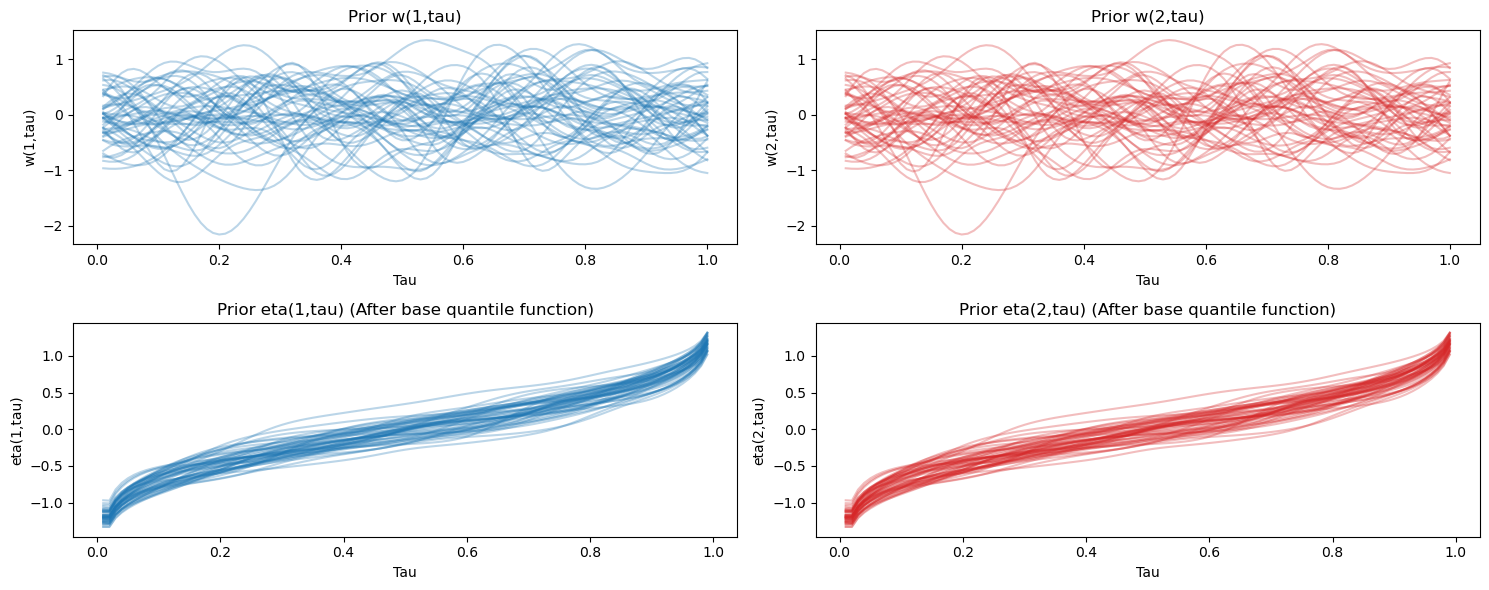

In [202]:
fig, ax = plt.subplots(2,2, figsize=(15,6))

tau_range = np.hstack([np.arange(0.01,1.01,0.01).reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, w_samples[:,0:100].T, c='tab:blue', alpha=0.3)
ax[0,1].plot(tau_range[:,0:100].T, w_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('w(1,tau)')
ax[0,1].set_ylabel('w(2,tau)')


ax[0,0].set_title('Prior w(1,tau)')
ax[0,1].set_title('Prior w(2,tau)')


# After base quantile function
ax[1,0].plot(tau_range[:,0:99].T, eta_samples_1.T, c='tab:blue', alpha=0.3)
ax[1,1].plot(tau_range[:,0:99].T, eta_samples_2.T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('eta(1,tau)')
ax[1,1].set_ylabel('eta(2,tau)')


ax[1,0].set_title('Prior eta(1,tau) (After base quantile function)')
ax[1,1].set_title('Prior eta(2,tau) (After base quantile function)')

plt.tight_layout()
plt.show()

## Plot prior over quantile function

In [209]:
def Q_joint_quantile_function(tau_input: float,
                      x_vals: np.ndarray,
                      w_samples_1: np.ndarray,
                      w_samples_2: np.ndarray,
                      sigma_1: float,
                      sigma_2: float,
                      tau_grid: np.ndarray,
                      mu: float,
                      gamma: float,
                      base_quantile_mean: float,
                      base_quantile_sd: float,
                      base_quantile_v: int=1,
                      base_quantile_dist: str='norm'):
    
    
    eta_out_1 = eta_function_i(tau_input=tau_input,
                               w_vals=w_samples_1,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_1,
                               dist=base_quantile_dist)
    
    eta_out_2 = eta_function_i(tau_input=tau_input,
                               w_vals=w_samples_2,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_2,
                               dist=base_quantile_dist)
    
    output = mu + gamma*x_vals + \
        ((1-x_vals)/2)*eta_out_1 + \
        ((1+x_vals)/2)*eta_out_2
    
    return output

@numba.njit
def Q_joint_quantile_function_vector(tau_input: np.ndarray,
                      x_vals: np.ndarray,
                      w_samples_1: np.ndarray,
                      w_samples_2: np.ndarray,
                      sigma_1: float,
                      sigma_2: float,
                      tau_grid: np.ndarray,
                      mu: float,
                      gamma: float,
                      base_quantile_mean: float,
                      base_quantile_sd: float,
                      base_quantile_v: int=1,
                      base_quantile_dist: str='norm'):
    
    
    eta_out_1 = eta_function_i_vector(tau_input=tau_input,
                               w_vals=w_samples_1,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_1,
                               dist=base_quantile_dist)
    
    eta_out_2 = eta_function_i_vector(tau_input=tau_input,
                               w_vals=w_samples_2,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_2,
                               dist=base_quantile_dist)
    
    output = mu + gamma*x_vals + \
        ((1-x_vals)/2)*eta_out_1 + \
        ((1+x_vals)/2)*eta_out_2
    
    return output

# Generate some fake data

In [234]:
np.random.seed(0)

In [235]:
x_vals = np.arange(-1,1, 0.01)
y_vals_true = 0 + 0.5*x_vals + np.random.normal(0,0.5,len(x_vals))

In [236]:
from scipy.stats import norm

## First Plot: Single sample for multiple tau

In [237]:
# Example X_vals and tau_vals
x_vals = np.arange(-1,1, 0.01)
tau_vals = np.arange(0,1,0.05)[1:]
mu = 0 
gamma = 1 

y_out = []
for t_in in tau_vals:
    y_out_t = Q_joint_quantile_function(tau_input=t_in,
                          x_vals=x_vals,
                          w_samples_1=w_samples[0,0:100],
                          w_samples_2=w_samples[0,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0,
                          base_quantile_sd=1,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
    
    y_out.append(y_out_t)

In [238]:
import matplotlib as mpl

cmap = plt.get_cmap('Reds')

# Normalizer
normala = mpl.colors.Normalize(vmin=0, vmax=2)
#  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normala)

Text(0, 0.5, 'Y')

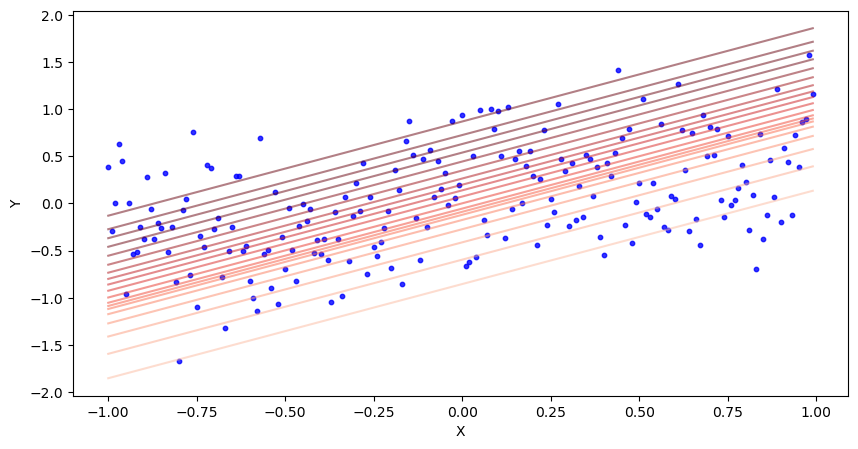

In [239]:
fig, ax = plt.subplots(figsize=(10,5))

for i,t_in in enumerate(tau_vals):
    
    ax.plot(x_vals, y_out[i], c=cmap(t_in+0.2), label=f'Tau {t_in}', alpha=0.5)

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Second Plot: Multiple sample for single tau

In [240]:
# Example X_vals and tau_vals
x_vals = np.arange(-1,1, 0.01)
tau_choice = 0.5

n_samples = 100
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])

y_out_005 = []
for i in range(n_samples):
    y_out_samp = Q_joint_quantile_function(tau_input=0.05,
                          x_vals=x_vals,
                          w_samples_1=w_samples[i,0:100],
                          w_samples_2=w_samples[i,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0,
                          base_quantile_sd=1,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
    
    y_out_005.append(y_out_samp)
    
y_out_50 = []
for i in range(n_samples):
    y_out_samp = Q_joint_quantile_function(tau_input=0.5,
                          x_vals=x_vals,
                          w_samples_1=w_samples[i,0:100],
                          w_samples_2=w_samples[i,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0,
                          base_quantile_sd=1,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
    
    y_out_50.append(y_out_samp)
    
y_out_95 = []
for i in range(n_samples):
    y_out_samp = Q_joint_quantile_function(tau_input=0.95,
                          x_vals=x_vals,
                          w_samples_1=w_samples[i,0:100],
                          w_samples_2=w_samples[i,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0,
                          base_quantile_sd=1,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
    
    y_out_95.append(y_out_samp)

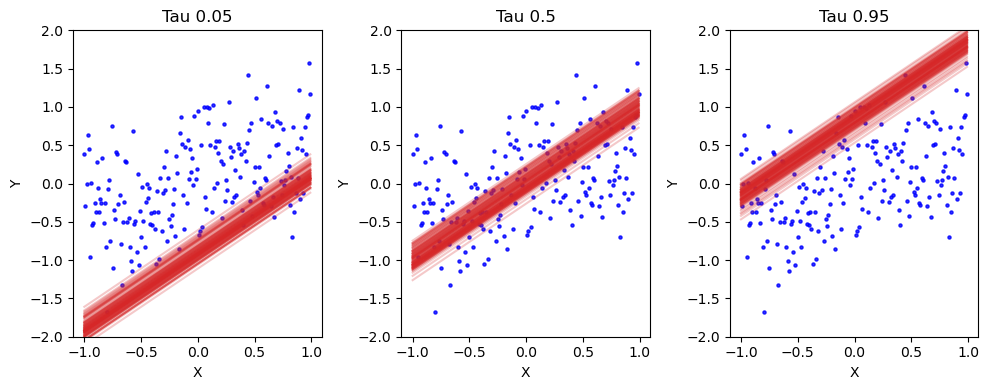

In [241]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

for i in range(n_samples):
    
    ax[0].plot(x_vals, y_out_005[i], color='tab:red', alpha=0.25)
    ax[1].plot(x_vals, y_out_50[i], color='tab:red', alpha=0.25)
    ax[2].plot(x_vals, y_out_95[i], color='tab:red', alpha=0.25)

for i,t in zip([0,1,2],[0.05, 0.5, 0.95]):
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].set_ylim(np.floor(np.min(y_vals_true)),np.ceil(np.max(y_vals_true)))
    ax[i].set_title(f'Tau {t}')
    ax[i].scatter(x_vals, y_vals_true, s=5, color='blue', alpha=0.8)

plt.tight_layout()

# MCMC Sampling

- Block (Metropolis in Gibbs):
- Block 1: Eta Function components, GP, lambda and rho
- Block 2: Remaining, mu, gamma, sigma1 and sigma2

## Likelihood Evaluation Function

- First need tau solver
- Needs to solve $y_i = Q_Y(\tau|x_i)$

In [242]:
def derivative_Q(tau_input: float,
                 x_vals: np.ndarray,
                 w_samples_1: np.ndarray,
                 w_samples_2: np.ndarray,
                 sigma_1: float,
                 sigma_2: float,
                 tau_grid: np.ndarray,
                 mu: float,
                 gamma: float,
                 base_quantile_mean: float,
                 base_quantile_sd: float,
                 base_quantile_v: int=1,
                 base_quantile_dist: str='norm'):
    
    # Get position where tau input falls on grid
    tau_max = len(tau_grid)
    t_l = get_interval(tau_input, tau_grid)
    t_l_1 = t_l-1
    
    if t_l >= len(tau_grid):
        return 0
    
    Q_y_tl = Q_joint_quantile_function(tau_input=tau_grid[t_l],
                                      x_vals=x_vals,
                                      w_samples_1=w_samples_1,
                                      w_samples_2=w_samples_2,
                                      sigma_1=sigma_1,
                                      sigma_2=sigma_2,
                                      tau_grid=tau_grid,
                                      mu=mu,
                                      gamma=gamma,
                                      base_quantile_mean=base_quantile_mean,
                                      base_quantile_sd=base_quantile_sd,
                                      base_quantile_v=base_quantile_v,
                                      base_quantile_dist=base_quantile_dist)
    
    Q_y_tl_1 = Q_joint_quantile_function(tau_input=tau_grid[t_l_1],
                                      x_vals=x_vals,
                                      w_samples_1=w_samples_1,
                                      w_samples_2=w_samples_2,
                                      sigma_1=sigma_1,
                                      sigma_2=sigma_2,
                                      tau_grid=tau_grid,
                                      mu=mu,
                                      gamma=gamma,
                                      base_quantile_mean=base_quantile_mean,
                                      base_quantile_sd=base_quantile_sd,
                                      base_quantile_v=base_quantile_v,
                                      base_quantile_dist=base_quantile_dist)
    
    deriv = (Q_y_tl - Q_y_tl_1)/(tau_grid[t_l] - tau_grid[t_l_1])
    
    #print(Q_y_tl)
    #print(Q_y_tl_1)
    
    return deriv

### Newton's Method to find Tau
- Doesnt seem to work, $\tau$ goes out of range?
- Also how to calculate derivatives of $\eta$?

In [243]:
tau_solve = 0.1
x_i = x_vals[32]
y_i = y_vals_true[32]

for _ in range(100):
    Q_y_k = Q_joint_quantile_function(tau_input=tau_solve,
                                          x_vals=x_i,
                                          w_samples_1=w_samples[0,0:100],
                                          w_samples_2=w_samples[0,100:200],
                                          sigma_1=0.5,
                                          sigma_2=0.5,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=0,
                                          base_quantile_sd=1,
                                          base_quantile_v=1,
                                          base_quantile_dist='norm')

    deriv_k = derivative_Q(tau_input=tau_solve,
                                          x_vals=x_i,
                                          w_samples_1=w_samples[0,0:100],
                                          w_samples_2=w_samples[0,100:200],
                                          sigma_1=0.5,
                                          sigma_2=0.5,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=0,
                                          base_quantile_sd=1,
                                          base_quantile_v=1,
                                          base_quantile_dist='norm')

    
    tau_solve = tau_solve - (Q_y_k - y_i)/deriv_k
    

#### Grid Search Approach
- Evaluate Q across all tau values and find the one containing y

In [282]:
def grid_search_deriv_approx(y_i:float,
                             x_i: np.ndarray,
                             w_samples_1: np.ndarray,
                             w_samples_2: np.ndarray,
                             sigma_1: float,
                             sigma_2: float,
                             tau_grid: np.ndarray,
                             mu: float,
                             gamma: float,
                             base_quantile_mean: float,
                             base_quantile_sd: float,
                             base_quantile_v: int=1,
                             base_quantile_dist: str='norm'):
    """
    Q_y_i_vals = np.array([Q_joint_quantile_function(tau_input=t,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist) for t in tau_grid])

    """
    
    Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)
    
    
    t_l = 0
    while True:
        if Q_y_i_vals[t_l] > y_i:
            
            break
        t_l += 1
        if t_l == len(tau_grid):
            break

    if t_l >= len(tau_grid)-1:
        tau_edge = 0.99999

        Q_y_edge = Q_joint_quantile_function(tau_input=tau_edge,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist) 

        deriv_Q_y = (Q_y_edge - Q_y_i_vals[-2])/(tau_edge - tau_grid[t_l-1])
    
    
    
    elif t_l == 0:
        tau_edge = 0.005
        Q_y_edge = Q_joint_quantile_function(tau_input=tau_edge,
                                      x_vals=x_i,
                                      w_samples_1=w_samples_1,
                                      w_samples_2=w_samples_2,
                                      sigma_1=sigma_1,
                                      sigma_2=sigma_2,
                                      tau_grid=tau_grid,
                                      mu=mu,
                                      gamma=gamma,
                                      base_quantile_mean=base_quantile_mean,
                                      base_quantile_sd=base_quantile_sd,
                                      base_quantile_v=base_quantile_v,
                                      base_quantile_dist=base_quantile_dist) 
        
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge)/(tau_grid[t_l] - tau_edge)
        #print(tau_grid[t_l])
    
    else:
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])
        
        #print(Q_y_i_vals[t_l])
        #print(Q_y_i_vals[t_l-1])
        #print(t_l)
        #print(t_l-1)
        
    #print(tau_grid[t_l])
    return deriv_Q_y
    

@numba.njit
def grid_search_deriv_approx_vector(y_i:float,
                             x_i: np.ndarray,
                             w_samples_1: np.ndarray,
                             w_samples_2: np.ndarray,
                             sigma_1: float,
                             sigma_2: float,
                             tau_grid: np.ndarray,
                             mu: float,
                             gamma: float,
                             base_quantile_mean: float,
                             base_quantile_sd: float,
                             base_quantile_v: int=1,
                             base_quantile_dist: str='norm'):

    
    
    Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)
    
    
    t_l = 0
    while True:
        if Q_y_i_vals[t_l] > y_i:
            
            break
        t_l += 1
        if t_l == len(tau_grid):
            break

    if t_l >= len(tau_grid)-1:
        tau_edge = 0.99999

        Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist) 

        deriv_Q_y = (Q_y_edge[0] - Q_y_i_vals[-2])/(tau_edge - tau_grid[t_l-1])
    
    
    elif t_l == 0:
        tau_edge = 0.005
        Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                      x_vals=x_i,
                                      w_samples_1=w_samples_1,
                                      w_samples_2=w_samples_2,
                                      sigma_1=sigma_1,
                                      sigma_2=sigma_2,
                                      tau_grid=tau_grid,
                                      mu=mu,
                                      gamma=gamma,
                                      base_quantile_mean=base_quantile_mean,
                                      base_quantile_sd=base_quantile_sd,
                                      base_quantile_v=base_quantile_v,
                                      base_quantile_dist=base_quantile_dist) 
        
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge[0])/(tau_grid[t_l] - tau_edge)
        #print(tau_grid[t_l])
    
    else:
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])
        
        #print(Q_y_i_vals[t_l])
        #print(Q_y_i_vals[t_l-1])
        #print(t_l)
        #print(t_l-1)
        
    #print(tau_grid[t_l])
    return deriv_Q_y
    

In [278]:
grid_search_deriv_approx(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples[0,0:100],
                          w_samples_2=w_samples[0,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0.0,
                          base_quantile_sd=1.0,
                          base_quantile_v=1,
                          base_quantile_dist='norm')

-97889.56649508457

In [271]:
y_i = y_vals_true[0]
x_i = x_vals[0]

Grid Search LL

In [301]:
@numba.njit(parallel=True)
def eval_ll(y_vals_true,
           x_vals,
            w_samples_1,
          w_samples_2,
          sigma_1,
          sigma_2,
          tau_grid,
          mu,
          gamma,
          base_quantile_mean=0.0,
          base_quantile_sd=1.0,
          base_quantile_v=1,
          base_quantile_dist='norm'):

    log_lik = 0

    for i in prange(1,len(y_vals_true)):

        y_i = y_vals_true[i]
        x_i = x_vals[i]

        ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                              x_i=x_i,
                              w_samples_1=w_samples_1,
                              w_samples_2=w_samples_2,
                              sigma_1=sigma_1,
                              sigma_2=sigma_2,
                              tau_grid=tau_grid,
                              mu=mu,
                              gamma=gamma,
                              base_quantile_mean=base_quantile_mean,
                              base_quantile_sd=base_quantile_sd,
                              base_quantile_v=base_quantile_v,
                              base_quantile_dist=base_quantile_dist)

        log_lik += np.log(ll_i)

    log_lik = -1 * log_lik
    
    return log_lik

In [303]:
%%timeit
eval_ll(y_vals_true,
        x_vals,
        w_samples_1=w_samples[0,0:100],
                          w_samples_2=w_samples[0,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0.0,
                          base_quantile_sd=1.0,
                          base_quantile_v=1,
                          base_quantile_dist='norm')

2.83 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [294]:
log_lik_store = []

for i in range(1,len(y_vals_true)):
    
    y_i = y_vals_true[i]
    x_i = x_vals[i]
    
    ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples[0,0:100],
                          w_samples_2=w_samples[0,100:200],
                          sigma_1=0.5,
                          sigma_2=0.5,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=0.0,
                          base_quantile_sd=1.0,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
    
    log_lik_store.append(np.log(ll_i))
    
log_lik = -1 * np.sum(log_lik_store)

In [116]:
y_i = y_vals_true[141]
x_i = x_vals[141]

ll_i = grid_search_deriv_approx(y_i=y_i,
                      x_i=x_i,
                      w_samples_1=w_samples[0,0:100],
                      w_samples_2=w_samples[0,100:200],
                      sigma_1=0.5,
                      sigma_2=0.5,
                      tau_grid=tau_grid,
                      mu=mu,
                      gamma=gamma,
                      base_quantile_mean=0,
                      base_quantile_sd=1,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

ll_i

8.965310660863944

Current Time:
- 1.88 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With vectorized Q func:
- 38.9 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Almost full vectorized:
- 6.76 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
With final parallelized loop
- 2.83 ms ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# GP Approx
- Tokdar 2007


GP Approx

In [320]:
import scipy as sp

In [672]:
def covariance_function_single_var_vector(knot_points: np.ndarray,
                                            input_tau: np.ndarray,
                                            kappa: float,
                                            rho: float,
                                            lambd:float):
    """ GP Covariance Function with

    Args:
        knot_points (np.array): M x 2 matrix with 1st-column being i index and 2nd column tau values
        input_tau (np.array): t x 2 matrix with 1st-column being i index and 2nd column tau values of desired grid
        kappa (float): kappa value
        rho (float): rho value
        lambd (float): lambd value

    Returns:
        _type_: Covariance
    """    

    tau_diffs = np.subtract.outer(knot_points[:,1], input_tau[:,1])
    rho_select = np.not_equal.outer(knot_points[:,0], input_tau[:,0])

    return (kappa**2)*(1+rho*rho_select - 1*rho_select)*np.exp(-(lambd**2)*(tau_diffs)**2)

In [1005]:
def calc_knot_approx(tau_in,
                     knot_points_t,
                     cov_mat_knots,
                     X_surrogates,
                     kappa,
                     rho,
                     lambd):
    # Uses Random sample of X surrogates
    m = len(knot_points_t)
    
    # Calc covariance matrix 
    knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
    knot_points_t = np.concatenate([knot_points_t,
                                knot_points_t]).reshape(-1,1)

    knot_points = np.hstack([knot_sub_ids, knot_points_t])


     # vector 
    cov_input_knots = covariance_function_single_var_vector(knot_points,
                                            tau_in,
                                            kappa,
                                            rho,
                                            lambd)
    
    
    A_mat = np.linalg.inv(sp.linalg.sqrtm(cov_mat_knots)) @ cov_input_knots


    f_xA = X_surrogates@A_mat
    
    return f_xA

def calc_knot_approx_v2(tau_in,
                        knot_points_t,
                        cov_mat_knots,
                        w_knot_points,
                        kappa,
                        rho,
                        lambd):
    
    # Uses W evaluated at knot points
    m = len(knot_points_t)
    
    # Calc covariance matrix 
    knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
    knot_points_t = np.concatenate([knot_points_t,
                                knot_points_t]).reshape(-1,1)

    knot_points = np.hstack([knot_sub_ids, knot_points_t])


     # vector 
    cov_input_knots = covariance_function_single_var_vector(knot_points,
                                            tau_in,
                                            kappa,
                                            rho,
                                            lambd)
    
    
    f_w_approx = w_knot_points @ np.linalg.inv(cov_mat_knots) @ cov_input_knots


    return f_w_approx

In [946]:
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots

# Calc covariance matrix 
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)

knot_points = np.hstack([knot_sub_ids, knot_points_t])
tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])

In [1012]:
# Some scratch for first version of knot approximation
kappa = 0.5
lambd = 0.5
rho = 0.5

# Matrix 
cov_mat_knots = covariance_mat_single_var(knot_points,
                             kappa=kappa,
                             rho=rho,
                             lambd=lambd)

m = len(np.arange(0.1,1,0.1))

X_surrogates_samples = np.random.multivariate_normal(np.zeros(m*2),
                                                     np.eye(m*2),
                                                     n_samples)

w_knot_approx_samples = np.random.multivariate_normal(np.zeros(m*2),
                                                     cov_mat_knots,
                                                     n_samples)

knot_approx_f_samples = np.array([calc_knot_approx(tau_input,
                                                   np.arange(0.1,1,0.1),
                                                   cov_mat_knots,
                                                   X_surrogates_samples[i,:],
                                                   kappa,
                                                   rho,
                                                   lambd)
                         for i in range(n_samples)])


knot_approx_f_w_knot_samples = np.array([calc_knot_approx_v2(tau_input,
                                                   np.arange(0.1,1,0.1),
                                                   cov_mat_knots,
                                                   w_knot_approx_samples[i,:],
                                                   kappa,
                                                   rho,
                                                   lambd)
                         for i in range(n_samples)])

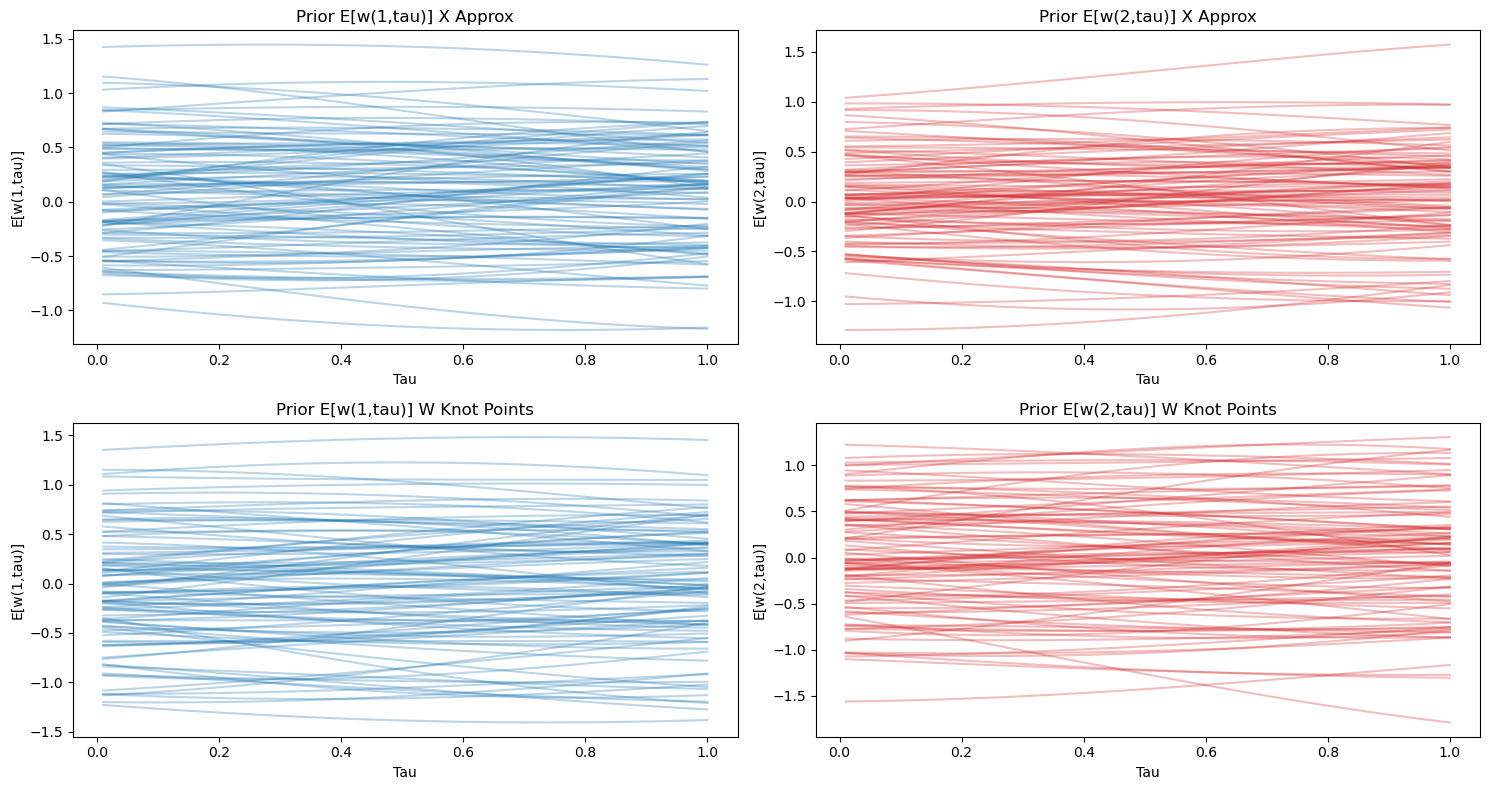

In [1013]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

tau_range = np.hstack([np.arange(0.01,1.01,0.01).reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, knot_approx_f_samples[:,0:100].T, c='tab:blue', alpha=0.3)

ax[0,1].plot(tau_range[:,0:100].T, knot_approx_f_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('E[w(1,tau)]')
ax[0,1].set_ylabel('E[w(2,tau)]')


ax[0,0].set_title('Prior E[w(1,tau)] X Approx')
ax[0,1].set_title('Prior E[w(2,tau)] X Approx')


ax[1,0].plot(tau_range[:,0:100].T, knot_approx_f_w_knot_samples[:,0:100].T, c='tab:blue', alpha=0.3)

ax[1,1].plot(tau_range[:,0:100].T, knot_approx_f_w_knot_samples[:,100:200].T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('E[w(1,tau)]')
ax[1,1].set_ylabel('E[w(2,tau)]')


ax[1,0].set_title('Prior E[w(1,tau)] W Knot Points')
ax[1,1].set_title('Prior E[w(2,tau)] W Knot Points')

plt.tight_layout()

In [1016]:
w_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=[n_samples])

w_samples_approx = np.array([calc_knot_approx_v2(tau_input,
                                                   np.arange(0.1,1,0.1),
                                                   cov_mat_knots,
                                                   w_knot_approx_samples[i,:],
                                                   kappa,
                                                   rho,
                                                   lambd)
                         for i in range(n_samples)])


eta_samples_1_approx = np.array([eta_function_i_vector(tau_grid[:-1], w_samples_approx[s,0:100],
                         tau_grid, 0.0,1.0,1,0.5,'norm') for s in range(n_samples)])

eta_samples_2_approx = np.array([eta_function_i(tau_grid[:-1], w_samples_approx[s,100:200],
                         tau_grid, 0.0,1.0,1,0.5,'norm') for s in range(n_samples)])


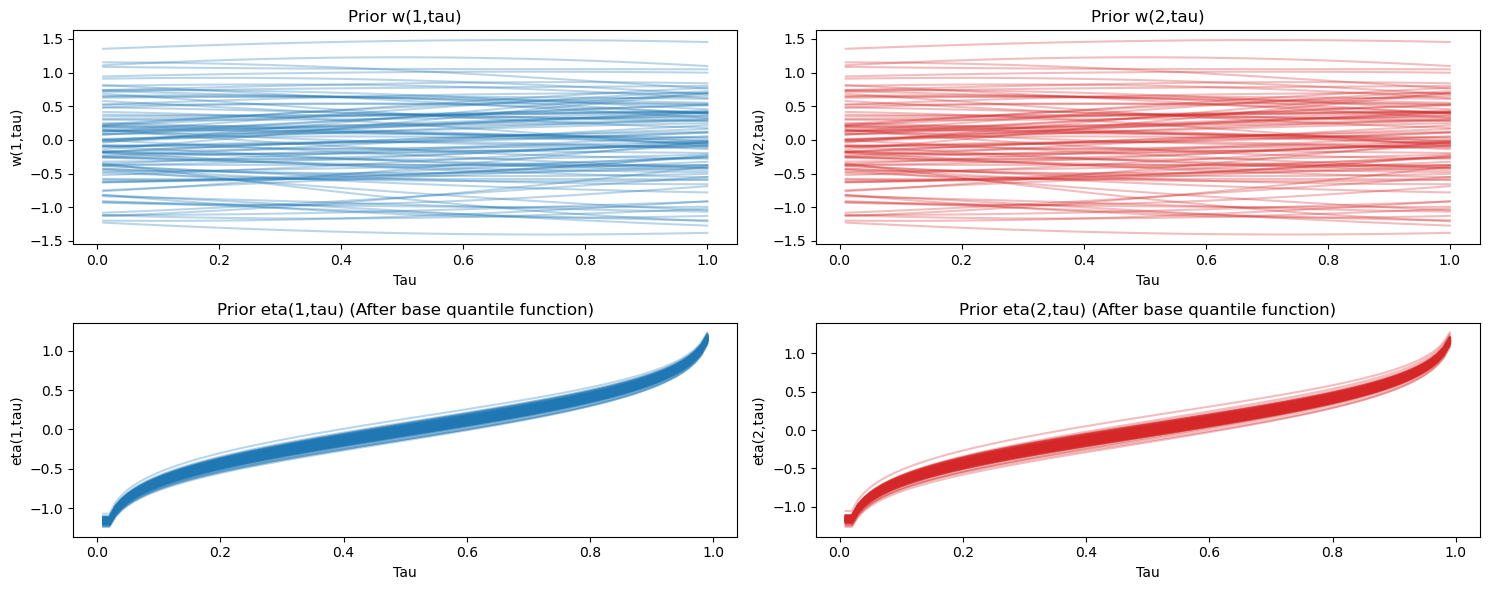

In [1017]:
fig, ax = plt.subplots(2,2, figsize=(15,6))

tau_range = np.hstack([np.arange(0.01,1.01,0.01).reshape(-1,1) for _ in range(n_samples)]).T

ax[0,0].plot(tau_range[:,0:100].T, w_samples_approx[:,0:100].T, c='tab:blue', alpha=0.3)
ax[0,1].plot(tau_range[:,0:100].T, w_samples_approx[:,0:100].T, c='tab:red', alpha=0.3)

ax[0,0].set_xlabel('Tau')
ax[0,1].set_xlabel('Tau')

ax[0,0].set_ylabel('w(1,tau)')
ax[0,1].set_ylabel('w(2,tau)')


ax[0,0].set_title('Prior w(1,tau)')
ax[0,1].set_title('Prior w(2,tau)')


# After base quantile function
ax[1,0].plot(tau_range[:,0:99].T, eta_samples_1_approx.T, c='tab:blue', alpha=0.3)
ax[1,1].plot(tau_range[:,0:99].T, eta_samples_2_approx.T, c='tab:red', alpha=0.3)

ax[1,0].set_xlabel('Tau')
ax[1,1].set_xlabel('Tau')

ax[1,0].set_ylabel('eta(1,tau)')
ax[1,1].set_ylabel('eta(2,tau)')


ax[1,0].set_title('Prior eta(1,tau) (After base quantile function)')
ax[1,1].set_title('Prior eta(2,tau) (After base quantile function)')

plt.tight_layout()
plt.show()

# MCMC Sampling Loop with Approximation

Setting priors for 
- W $\sim$ GP Thingy (Just draw from multviariate)?
- $\kappa^2 \sim  IG(3,1/3)$
- $\lambda^2 \sim Ga(5,1/10)$
- $\rho \sim Unif(0,1)$
- $\sigma_1, \sigma_2 \sim Ga(2,2)$
- $\mu \sim N(0,1)$
- $\gamma \sim N(0,1)$

Block metropolis with blocks
- W, $\kappa^2$, $\lambda^2$, $\rho$
-  $\sigma_1, \sigma_2, \mu, \gamma$

In [1046]:
w_knot_prop  = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots)

# Update w_sample
w_approx_prop = calc_knot_approx_v2(tau_input,
                               np.arange(0.1,1,0.1),
                               cov_mat_knots_current,
                               w_knot_prop,
                               kappa_current,
                               rho_current,
                               lambd_current)

In [1053]:
log_am_lambda_block1 = 1
am_lambda_block1 = np.exp(log_am_lambda_block1)
am_cov_block1 = np.eye(len(w_knot_points_current)+3)

In [1199]:
# Generate step size sequence
n_steps = 5000
C = 0.5
lambda_step_size = 3
alpha_step_size = 0.3
step_sizes = C/(np.arange(1,n_steps+10)**alpha_step_size)

In [1200]:
(update_block.reshape(-1,1) @ update_block.reshape(-1,1).T).shape

(21, 21)

In [1201]:
step_sizes

array([0.5       , 0.4061262 , 0.35961155, ..., 0.03882368, 0.03882136,
       0.03881903])

In [1202]:
from scipy.stats import multivariate_normal

In [1210]:
rho_current=0.5

In [1211]:
np.log(rho_current/(1-rho_current))

0.0

In [1209]:
rho_current

0.0

In [1217]:
np.exp(0.1)

1.1051709180756477

In [1268]:
# Set MCMC Parameters
s = time.time()
n_steps = 5000
lol_cnt = 0

# Set adaptive metropolis step sizes
C = 3
lambda_step_size = 3
alpha_step_size = 0.3
step_sizes = C/(np.arange(1,n_steps+10)**alpha_step_size)
a_target = 0.4

# Set knot points for approx
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)
knot_points = np.hstack([knot_sub_ids, knot_points_t])

# Prepare tau grid
tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])


#### Initialize variables

## GP Related hyperparameters
kappa_current = 0.5
rho_current = 0
lambd_current = 0.5

## Regression related parametrs
mu_current = 0.5
gamma_current = 0.5
sigma_1_current = 0.5
sigma_2_current = 0.5

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots)
#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)



# Storage variables
w_approx_store = []
kappa_store = []
lambda_store = []
rho_store = []
sigma_store = []
mu_store = []
gamma_store = []


kappa_accept = 0
lambda_accept = 0
rho_accept= 0 
sigma_accept = 0
mu_accept = 0
gamma_accept = 0

# initialise adaptive metropolis
am_lamb_block1 = 0.1
log_am_lamb_block1 = np.log(am_lamb_block1)
am_cov_block1 = 0.5*np.eye(len(w_knot_points_current)+2)
mu_block1 = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([rho_current])])

rho_current = 0.5
checks = []
prop_check = []
for mc_i in range(n_steps): 
     
    print(mc_i)
    
    #### Generate Sample for W, kappa, tau, lamdba
    
    am_lamb_block1 = np.exp(log_am_lamb_block1)
    proposal_vec  = np.random.multivariate_normal(mu_block1,
                                                 am_lamb_block1*am_cov_block1)
    
    w_knot_prop = proposal_vec[0:len(w_knot_points_current)]
    
    kappa_prop = proposal_vec[len(w_knot_points_current)]
    lambd_prop = proposal_vec[len(w_knot_points_current)+1]
    #log_rho_prop = proposal_vec[len(w_knot_points_current)+2]
    
    prop_check.append(proposal_vec)
    
    rho_prop = 0.5#1/(1+e**log_rho_prop)
    
    cov_mat_knot_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_prop,
                             rho=rho_prop,
                             lambd=lambd_prop)
    
    # Update w_sample
    w_approx_prop = calc_knot_approx_v2(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knot_prop,
                                   w_knot_prop,
                                   kappa_prop,
                                   rho_prop,
                                   lambda_prop)

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_prop[0:100],
                      w_samples_2=w_approx_prop[100:200],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:100],
                      w_samples_2=w_approx_current[100:200],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    
    log_prior_prop = multivariate_normal.logpdf(w_knot_prop,np.zeros(m*2),cov_mat_knot_prop, allow_singular=True) +\
                     gamma.logpdf(1/kappa_prop**(2),  a=3, scale=3) +\
                     gamma.logpdf(lambd_prop**(2),  a=5, scale=10) 
    
    log_prior_current = multivariate_normal.logpdf(w_knot_points_current,np.zeros(m*2),cov_mat_knots, allow_singular=True) +\
                 gamma.logpdf(1/kappa_current**(2),  a=3, scale=3) +\
                 gamma.logpdf(lambd_current**(2),  a=5, scale=10) 
    
    a = np.exp(min(0,  (ll_prop + log_prior_prop) - (log_prior_current + ll_curr) ))
    print(a)
    if np.random.uniform(0,1) < a:
        w_knot_points_current = w_knot_prop
        kappa_current = kappa_prop
        lambd_current = lambd_prop
        kappa_current = kappa_prop
        rho_current = rho_prop
        
        lol_cnt += 1
        print('hit')
    else: 
        w_knot_points_current = w_knot_points_current
        kappa_current = kappa_current
        lambd_current = lambd_current
        kappa_current = kappa_current
        rho_current = rho_current
    
    # Update w 
    w_approx_current = calc_knot_approx_v2(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)
    
    w_approx_store.append(w_approx_current)
    
    # Update AM sampling parameters
    update_block = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([np.log(rho_current/(1-rho_current))])])
    

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block1 = log_am_lamb_block1 + step_sizes[mc_i]*(a - a_target)
    print(log_am_lamb_block1)
    mu_block1_update = mu_block1 + step_sizes[mc_i]*(update_block - mu_block1)
    
    am_cov_block1 = am_cov_block1 + step_sizes[mc_i]*( (update_block - mu_block1).reshape(-1,1) @\
                                                  ((update_block - mu_block1).reshape(-1,1).T) - am_cov_block1)
    
    mu_block1 = mu_block1_update
    """
    #### Sample kappa inv sq samp
    kappa_current, kappa_accept_m = metropolis_step_kappa(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid=tau_grid,
                                                        y_vals=y_vals_true,
                                                        x_vals=x_vals)

    kappa_accept += kappa_accept_m
    
    kappa_store.append(kappa_current)
    
    #### Sample lambda
    lambda_current, lambda_accept_m = metropolis_step_lambda(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid,
                                                        y_vals_true,
                                                        x_vals)
    
    lambda_accept += lambda_accept_m
    
    #### Sample rho
    rho_current, rho_accept_m = metropolis_step_lambda(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid,
                                                        y_vals_true,
                                                        x_vals)
    
    rho_accept += rho_accept_m
    
    rho_store.append(rho_current)
    
    #### Sample sigma 1 sigma 2
    sigma_1_current, sigma_2_current,\
        sigma_accept_m = metropolis_step_sigmas(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    
    sigma_accept += sigma_accept_m
    
    sigma_store.append(np.array([sigma_1_current, sigma_2_current]))
    
    #### Sample mu
    mu_current, mu_accept_m = metropolis_step_mu(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    mu_accept += mu_accept_m
    
    mu_store.append(mu_current)
    
    #### Sample gamma
    gamma_current, gamma_accept_m = metropolis_step_gamma(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    gamma_accept += gamma_accept_m
    gamma_store.append(gamma_current)
    
    if mc_i%100 == 0:
        e = time.time()
        print('Step: ', mc_i, ' Time Taken: ', e-s)
        s = time.time()
        
    """

0
1.0
hit
-0.5025850929940456
1
1.0
hit
0.9594692204471782
2
1.0
hit
2.254070788431934
3
1.0
hit
3.441627908127539
4
1.0
hit
4.552288861023556
5
1.0
hit
5.603832086945714
6
1.0
hit
6.607853772491557
7
1.0
hit
7.572449888774221
8
1.0
hit
8.503557233123438
9
1.0
hit
9.405694253652527
10
1.0
hit
10.282401708659018
11
1.0
hit
11.136520213786458
12
1.0
hit
11.97037322113712
13
1.0
hit
12.785892241215358
14
1.0
hit
13.584705247392373
15
1.0
hit
14.368200754358885
16


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/4018248489.py:96: RuntimeWarning: covariance is not positive-semidefinite.
  proposal_vec  = np.random.multivariate_normal(mu_block1,
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/4018248489.py:96: RuntimeWarning: covariance is not positive-semidefinite.
  proposal_vec  = np.random.multivariate_normal(mu_block1,
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/4018248489.py:96: RuntimeWarning: covariance is not positive-semidefinite.
  proposal_vec  = np.random.multivariate_normal(mu_block1,
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/4018248489.py:96: RuntimeWarning: covariance is not positive-semidefinite.
  proposal_vec  = np.random.multivariate_normal(mu_block1,
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/4018248489.py:96: RuntimeWarning: covariance is not positive-semidefinite.
  proposal_vec  = np.random.multivariate_normal(mu_block1,
/var/

1.0
hit
15.137575326377751
17
1.0
hit
15.893869498090293
18
1.0
hit
16.63799540492679
19
1.0
hit
17.37075836169322
20
1.0
hit
18.092873944136745
21
1.0
hit
18.804981675369145
22
1.0
hit
19.50765611224573
23
1.0
hit
20.201415914807697
24
1.0
hit
20.886731332745413
25
1.0
hit
21.56403043617484
26
1.0
hit
22.23370434059518
27
1.0
hit
22.89611161892782
28
1.0
hit
23.55158205109393
29
1.0
hit
24.20041982960174
30
1.0
hit
24.84290631525067
31
1.0
hit
25.47930241831856
32
1.0
hit
26.109850666049297
33
1.0
hit
26.734777005867176
34
1.0
hit
27.35429238475418
35
1.0
hit
27.968594138077947
36
1.0
hit
28.577867215434072
37
1.0
hit
29.182285266452773
38
1.0
hit
29.782011605777758
39
1.0
hit
30.377200073372368
40
1.0
hit
30.967995803803653
41
1.0
hit
31.554535916089584
42


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/78785855.py:61: RuntimeWarning: overflow encountered in matmul
  f_w_approx = w_knot_points @ np.linalg.inv(cov_mat_knots) @ cov_input_knots
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/78785855.py:61: RuntimeWarning: overflow encountered in matmul
  f_w_approx = w_knot_points @ np.linalg.inv(cov_mat_knots) @ cov_input_knots
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/78785855.py:61: RuntimeWarning: overflow encountered in matmul
  f_w_approx = w_knot_points @ np.linalg.inv(cov_mat_knots) @ cov_input_knots
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/78785855.py:61: RuntimeWarning: overflow encountered in matmul
  f_w_approx = w_knot_points @ np.linalg.inv(cov_mat_knots) @ cov_input_knots
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/78785855.py:61: RuntimeWarning: overflow encountered in matmul
  f_w_approx = w_knot_points @ np.linalg.inv(cov

LinAlgError: SVD did not converge

In [1334]:
## GP Related hyperparameters
kappa_current = 0.5
rho_current = 0.5
lambd_current = 0.5

## Regression related parametrs
mu_current = 0.5
gamma_current = 0.5
sigma_1_current = 0.5
sigma_2_current = 0.5

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots)
#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)



# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_current[0:100],
                  w_samples_2=w_approx_current[100:200],
                  sigma_1=sigma_1_current,
                  sigma_2=sigma_2_current,
                  tau_grid=tau_grid,
                  mu=mu_current,
                  gamma=gamma_current,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')
ll_prop

-253.3737629904948

In [1317]:
w_knot_prop

array([-0.49174038, -0.27829174, -0.51664816, -0.49459783, -0.74391188,
       -0.77564521, -0.48775859, -0.75898759, -0.14935333, -0.7389906 ,
       -0.54797699, -0.65462727, -0.62221853, -0.58086322, -0.60009099,
       -0.4307108 , -0.27301427, -0.71565003])

In [1318]:
w_knot_points_current

array([-0.1711214 , -0.23515953, -0.29801851, -0.35882575, -0.4167631 ,
       -0.4710897 , -0.52115953, -0.56643276, -0.60648136, -0.5143413 ,
       -0.54023296, -0.56707386, -0.59463556, -0.62262569, -0.65071216,
       -0.67854631, -0.70578309, -0.73209712])

In [1320]:
w_knot_prop

array([-0.49174038, -0.27829174, -0.51664816, -0.49459783, -0.74391188,
       -0.77564521, -0.48775859, -0.75898759, -0.14935333, -0.7389906 ,
       -0.54797699, -0.65462727, -0.62221853, -0.58086322, -0.60009099,
       -0.4307108 , -0.27301427, -0.71565003])

In [1328]:
np.linalg.inv(cov_mat_knot_prop)

array([[ 1.42836384e+13, -9.05827308e+13,  2.37815477e+14,
        -3.22541942e+14,  2.16152694e+14, -2.49501471e+13,
        -6.15820278e+13,  3.90307275e+13, -7.62568855e+12,
        -3.47142056e+12,  1.86284530e+13, -3.44526927e+13,
         9.13894258e+12,  6.20506871e+13, -1.08149926e+14,
         8.35485262e+13, -3.24564454e+13,  5.16387565e+12],
       [-8.92263605e+13,  5.82993632e+14, -1.60351852e+15,
         2.36395695e+15, -1.92668093e+15,  7.29210816e+14,
         4.11280356e+13, -1.28983799e+14,  3.11201718e+13,
         1.03090932e+13, -4.02472102e+13, -1.75876543e+12,
         2.82041958e+14, -6.96606877e+14,  8.32597369e+14,
        -5.55650647e+14,  1.99537501e+14, -3.02224203e+13],
       [ 2.28389362e+14, -1.56609458e+15,  4.61404173e+15,
        -7.56439362e+15,  7.43898621e+15, -4.36891962e+15,
         1.39924699e+15, -1.74413471e+14, -6.84299429e+12,
         2.31762235e+13, -2.29066084e+14,  9.51998697e+14,
        -2.20331440e+15,  3.13141365e+15, -2.81311711e

In [1536]:
w_knot_prop = proposal_vec[0:len(w_knot_points_current)]


#w_knot_prop = np.random.multivariate_normal(np.zeros(m*2),
#                                             cov_mat_knot_prop)

kappa_prop = proposal_vec[len(w_knot_points_current)]
lambd_prop = proposal_vec[len(w_knot_points_current)+1]
#log_rho_prop = proposal_vec[len(w_knot_points_current)+2]

prop_check.append(proposal_vec)

rho_prop = 0.5#1/(1+e**log_rho_prop)

cov_mat_knot_prop = covariance_mat_single_var(knot_points,
                         kappa=0.5,
                         rho=0.5,
                         lambd=0.5)

w_knot_prop = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots)

# Update w_sample
w_approx_prop = calc_knot_approx_v2(tau_input,
                               np.arange(0.1,1,0.1),
                               cov_mat_knot_prop,
                               w_knot_prop,
                               0.5,
                               0.5,
                               0.5)

# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_prop[0:100],
                  w_samples_2=w_approx_prop[100:200],
                  sigma_1=sigma_1_current,
                  sigma_2=sigma_2_current,
                  tau_grid=tau_grid,
                  mu=mu_current,
                  gamma=gamma_current,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

ll_prop

nan

In [1762]:
y_vals_true = y_vals_true
x_vals = x_vals
w_samples_1 = w_approx_prop[0:100]
w_samples_2 = w_approx_prop[100:200]
sigma_1 = sigma_1_current
sigma_2 = sigma_2_current
tau_grid = tau_grid
mu = mu_current
gamma = gamma_current
base_quantile_mean=0.0
base_quantile_sd=1.0
base_quantile_v=1
base_quantile_dist='norm'

lol_store = []
log_lik = 0

for i in range(1,len(y_vals_true)):

    y_i = y_vals_true[i]
    x_i = x_vals[i]

    ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)
    
    if ll_i < 0:
        print(i)
        print(y_i)
        print(x_i)
        
        
    log_lik += np.log(ll_i)
    lol_store.append(ll_i)
    
log_lik = -1 * log_lik



In [1770]:
[np.log(x) for x in lol_store]

[0.384694379962581,
 0.23224296787743015,
 1.0232122909664885,
 0.6385439179477178,
 2.1518732651775014,
 0.23245182033693676,
 0.8814738900849356,
 0.7795402633211665,
 0.3838320180358024,
 0.5596544196468763,
 0.36578780212338174,
 0.2508939888536361,
 0.5890209878081317,
 0.3527766927496428,
 0.4183465681793122,
 0.3820120346962677,
 0.8794231732819698,
 0.43747227894631824,
 1.863977868159364,
 -3.22093025516306,
 0.27623084027472883,
 0.23489490659601156,
 1.6563750688496395,
 1.1013157901319306,
 -3.2128655629649203,
 0.6189077949217764,
 0.8773682423962323,
 0.4183076863041353,
 0.3843745363359086,
 0.5287492052546928,
 0.38145668101892716,
 1.8612193534775472,
 -3.200095828493253,
 1.0729280911023877,
 0.5279651355972256,
 0.2883434173122442,
 0.2724620658221349,
 1.072063563288078,
 0.9987559035317879,
 2.1447248735103392,
 -3.187487106215287,
 -3.1859221357492244,
 0.7615302705885661,
 1.2483633823957618,
 1.1532852157043367,
 2.599483458198243,
 0.24257749219992683,
 -3.1765

In [1765]:
lol_store

[1.469165246483882,
 1.2614261776391291,
 2.782117395825176,
 1.8937214569942877,
 8.600955185536527,
 1.2616896571120253,
 2.4144557275386647,
 2.1804695931841738,
 1.4678988404398283,
 1.7500676068009187,
 1.4416492952756863,
 1.2851738343578578,
 1.8022231529928967,
 1.423013338754979,
 1.5194471752038294,
 1.4652297186214789,
 2.4095094360631486,
 1.5487873640213798,
 6.449340439643124,
 0.0399179071441047,
 1.3181521115052208,
 1.2647758421496267,
 5.24028071702646,
 3.0081214776582295,
 0.040241134390672784,
 1.8568988195641496,
 2.4045631445876436,
 1.5193880973969607,
 1.4686954184830168,
 1.6968086214395535,
 1.4644162238186669,
 6.431574354621294,
 0.04075829798493302,
 2.923928506778274,
 1.6954787267181344,
 1.3342154181295907,
 1.3131936430464053,
 2.921401781626572,
 2.714902126410264,
 8.539691418737426,
 0.04127546157928208,
 0.041340107028542405,
 2.1415508666155696,
 3.484635272655558,
 3.1685853159353154,
 13.45678524735603,
 1.2745300114711757,
 0.04172797972434861,

In [1640]:
x_i = x_vals[140]
y_i = y_vals_true[140]


grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)

-12.321430402987698

In [1596]:
tau_grid = np.array([0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 , 0.16 , 0.17 ,
       0.18 , 0.19 , 0.2  , 0.21 , 0.22 , 0.23 , 0.24 , 0.25 , 0.26 ,
       0.27 , 0.28 , 0.29 , 0.3  , 0.31 , 0.32 , 0.33 , 0.34 , 0.35 ,
       0.36 , 0.37 , 0.38 , 0.39 , 0.4  , 0.41 , 0.42 , 0.43 , 0.44 ,
       0.45 , 0.46 , 0.47 , 0.48 , 0.49 , 0.5  , 0.51 , 0.52 , 0.53 ,
       0.54 , 0.55 , 0.56 , 0.57 , 0.58 , 0.59 , 0.6  , 0.61 , 0.62 ,
       0.63 , 0.64 , 0.65 , 0.66 , 0.67 , 0.68 , 0.69 , 0.7  , 0.71 ,
       0.72 , 0.73 , 0.74 , 0.75 , 0.76 , 0.77 , 0.78 , 0.79 , 0.8  ,
       0.81 , 0.82 , 0.83 , 0.84 , 0.85 , 0.86 , 0.87 , 0.88 , 0.89 ,
       0.9  , 0.91 , 0.92 , 0.93 , 0.94 , 0.95 , 0.96 , 0.97 , 0.98 ,
       0.99 , 1.   ])

In [1728]:
Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)

In [1729]:
Q_y_i_vals

array([-0.51139896, -0.51097014, -0.37881572, -0.2951692 , -0.23232941,
       -0.18125415, -0.1377996 , -0.09970494, -0.06559482, -0.03456739,
       -0.00599768,  0.02056605,  0.04546153,  0.06894823,  0.09123007,
        0.11247041,  0.13280231,  0.15233569,  0.17116251,  0.18936055,
        0.20699628,  0.22412699,  0.2408025 ,  0.25706642,  0.27295721,
        0.28850899,  0.30375226,  0.31871436,  0.33342002,  0.34789163,
        0.36214965,  0.37621279,  0.3900983 ,  0.40382211,  0.41739902,
        0.43084284,  0.44416649,  0.45738213,  0.47050125,  0.48353476,
        0.49649305,  0.50938604,  0.5222233 ,  0.53501404,  0.5477672 ,
        0.56049149,  0.57319541,  0.58588733,  0.5985755 ,  0.61126809,
        0.62397325,  0.63669913,  0.6494539 ,  0.66224581,  0.67508324,
        0.6879747 ,  0.70092891,  0.71395479,  0.72706158,  0.74025882,
        0.75355644,  0.76696481,  0.78049481,  0.79415788,  0.80796613,
        0.82193239,  0.83607036,  0.85039467,  0.86492106,  0.87

In [1754]:
Q_joint_quantile_function_vector(tau_input=np.array([0.005]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 

[0]
asddas
[0]
asddas


array([-0.51163734])

In [1755]:
x_i = x_vals[140]

Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)
    
print('asd')
    
t_l = 0
while True:
    if Q_y_i_vals[t_l] > y_i:

        break
    t_l += 1
    if t_l == len(tau_grid):
        break

if t_l >= len(tau_grid)-1:
    tau_edge = 0.99999

    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist) 

    deriv_Q_y = (Q_y_edge[0] - Q_y_i_vals[-2])/(tau_edge - tau_grid[t_l-1])


elif t_l == 0:
    tau_edge = 0.005
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 

    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge[0])/(tau_grid[t_l] - tau_edge)
    #print(tau_grid[t_l])
    print('2')

else:
    print('3')
    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])

    #print(Q_y_i_vals[t_l])
    #print(Q_y_i_vals[t_l-1])
    #print(t_l)
    #print(t_l-1)

#print(tau_grid[t_l])

[ 0  1  2  3  4  5  6  8  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[ 0  1  2  3  4  5  6  8  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
asd
[0]
asddas
[0]
asddas
2


In [1761]:
def grid_search_deriv_approx_vector(y_i:float,
                             x_i: np.ndarray,
                             w_samples_1: np.ndarray,
                             w_samples_2: np.ndarray,
                             sigma_1: float,
                             sigma_2: float,
                             tau_grid: np.ndarray,
                             mu: float,
                             gamma: float,
                             base_quantile_mean: float,
                             base_quantile_sd: float,
                             base_quantile_v: int=1,
                             base_quantile_dist: str='norm'):

    
    
    Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)
    
    
    t_l = 0
    while True:
        if Q_y_i_vals[t_l] > y_i:
            
            break
        t_l += 1
        if t_l == len(tau_grid):
            break

    if t_l >= len(tau_grid)-1:
        tau_edge = 0.99999

        Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist) 

        deriv_Q_y = (Q_y_edge[0] - Q_y_i_vals[-2])/(tau_edge - tau_grid[t_l-1])
    
    
    elif t_l == 0:
        tau_edge = 0.005
        Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                      x_vals=x_i,
                                      w_samples_1=w_samples_1,
                                      w_samples_2=w_samples_2,
                                      sigma_1=sigma_1,
                                      sigma_2=sigma_2,
                                      tau_grid=tau_grid,
                                      mu=mu,
                                      gamma=gamma,
                                      base_quantile_mean=base_quantile_mean,
                                      base_quantile_sd=base_quantile_sd,
                                      base_quantile_v=base_quantile_v,
                                      base_quantile_dist=base_quantile_dist) 
        
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge[0])/(tau_grid[t_l] - tau_edge)
        #print(tau_grid[t_l])
    
    else:
        deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])
        
        #print(Q_y_i_vals[t_l])
        #print(Q_y_i_vals[t_l-1])
        #print(t_l)
        #print(t_l-1)
        
    #print(tau_grid[t_l])
    return deriv_Q_y

def eta_function_i(tau_input: np.ndarray,
                 w_vals: np.ndarray,
                 tau_grid: np.ndarray,
                 mean: float,
                 sd: float,
                 v: int,
                 sigma: float,
                 dist: str='norm') -> float:
    
    
    # Calculate xi function from GP inputs w
    c_vals = np.exp(w_vals)
    
    # Apply logistic transform
    if len(c_vals.shape) > 1:  # If multiple samples of w_vals inputted (useful for plotting)
        
        # if tau_input is a vector
        if hasattr(tau_input, "__len__"): # if multiple tau values
            xi_vals = np.array([[logistic_transform(t, tau_grid, c_vals[s,:]) for t in tau_input]
                                for s in range(c_vals.shape[0])])
        else: # if single tau value
            xi_vals = np.array([logistic_transform(tau_input, tau_grid, c_vals[s,:]) for s in range(c_vals.shape[0])])
            
    else:  # if single w val (as in MCMC loop)
        if hasattr(tau_input, "__len__"): # if multiple tau values
            xi_vals = np.array([logistic_transform(t, tau_grid, c_vals) for t in tau_input])  
        else:  # if single tau value
            xi_vals = logistic_transform(tau_input, tau_grid, c_vals)
    
    # Apply base quantile function
    eta_out = sigma * base_quantile_function(xi_vals,
                                                 mean,
                                                 sd,
                                                 v=v,
                                                 dist=dist)
    
    return eta_out

def eta_function_i_vector(tau_input: np.ndarray,
                 w_vals: np.ndarray,
                 tau_grid: np.ndarray,
                 mean: float,
                 sd: float,
                 v: int,
                 sigma: float,
                 dist: str='norm'):
    
    
    c_vals = np.exp(w_vals)
    
    # Apply logistic transform

    xi_vals = logistic_transform_vector(tau_input, tau_grid, c_vals)

    # Apply 

    if dist == 'norm':
        eta_out = sigma * numba_norm.ppf(xi_vals,
                                     mean,
                                     sd)
    
    
    return eta_out

def logistic_transform_vector(tau_input: Union[float, np.ndarray],
                       tau_grid: np.ndarray,
                       c_vals_i: np.ndarray):
    
    # Calc grid distance
    trapz_len = tau_grid[1] - tau_grid[0]
    
    # Calc normalizing constant
    norm_const = calc_grid_trapezoidal(tau_grid,
                                       c_vals_i,
                                       len(tau_grid)-1)
    
    # Get position where tau input falls on grid
    t_ls = get_interval_vector(tau_input, tau_grid).astype('int')
    t_ls_1 = t_ls-1
    #print(t_ls)
    """
    if hasattr(tau_input, "__len__"):
        t_ls = t_ls.astype('int')
    else:
        t_ls = int(t_ls)
    
    t_ls_1 = t_ls-1
    """

    #e_i
    #c_samp_repeat = np.repeat(c_vals_i[:,np.newaxis],len(tau_input), axis=1).T
    c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                    len(tau_input))).T
    
    e_t_l = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls) / norm_const

    if len(t_ls) == 1:
        if t_ls[0] == 0:
            #print('asddas')
            return e_t_l-1e-5 # Specific edge case when tau input is at left boundary 
    
    e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls_1) / norm_const

    e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
                e_t_l_1*(tau_grid[t_ls]-tau_input) - \
                (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(c_vals_i[t_ls]-c_vals_i[t_ls_1])) / \
                (tau_grid[t_ls] - tau_grid[t_ls_1])
    
    return e_tau_hat

def Q_joint_quantile_function_vector(tau_input: np.ndarray,
                      x_vals: np.ndarray,
                      w_samples_1: np.ndarray,
                      w_samples_2: np.ndarray,
                      sigma_1: float,
                      sigma_2: float,
                      tau_grid: np.ndarray,
                      mu: float,
                      gamma: float,
                      base_quantile_mean: float,
                      base_quantile_sd: float,
                      base_quantile_v: int=1,
                      base_quantile_dist: str='norm'):
    
    
    eta_out_1 = eta_function_i_vector(tau_input=tau_input,
                               w_vals=w_samples_1,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_1,
                               dist=base_quantile_dist)
    
    eta_out_2 = eta_function_i_vector(tau_input=tau_input,
                               w_vals=w_samples_2,
                               tau_grid=tau_grid,
                               mean=base_quantile_mean,
                               sd=base_quantile_sd,
                               v=base_quantile_v,
                               sigma=sigma_2,
                               dist=base_quantile_dist)
    
    output = mu + gamma*x_vals + \
        ((1-x_vals)/2)*eta_out_1 + \
        ((1+x_vals)/2)*eta_out_2
    
    return output

In [1644]:
Q_y_i_vals[t_l] - Q_y_edge[0]

-0.06160715201493849

In [1645]:
tau_grid[t_l] - tau_edge

0.005

In [1646]:
-0.06160715201493849 / 0.005

-12.321430402987698

In [1699]:

@numba.njit
def eta_function_i_vector(tau_input: np.ndarray,
                 w_vals: np.ndarray,
                 tau_grid: np.ndarray,
                 mean: float,
                 sd: float,
                 v: int,
                 sigma: float,
                 dist: str='norm'):
    
    
    c_vals = np.exp(w_vals)
    
    # Apply logistic transform

    xi_vals = logistic_transform_vector(tau_input, tau_grid, c_vals)

    # Apply 

    if dist == 'norm':
        eta_out = sigma * numba_norm.ppf(xi_vals,
                                     mean,
                                     sd)
    
    
    return eta_out

In [1694]:
c_vals = np.exp(w_samples_2)

logistic_transform_vector(np.array([0.001]), tau_grid, c_vals)

array([0.00695845])

In [1680]:
c_vals_i = c_vals
tau_input = np.array([0.999])


# Calc grid distance
trapz_len = tau_grid[1] - tau_grid[0]

# Calc normalizing constant
norm_const = calc_grid_trapezoidal(tau_grid,
                                   c_vals_i,
                                   len(tau_grid)-1)

# Get position where tau input falls on grid
t_ls = get_interval_vector(tau_input, tau_grid).astype('int')
t_ls_1 = t_ls-1

if t_ls == 0:
    
    e_tau_hat = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls) / norm_const
    
else:
    
    #e_i
    #c_samp_repeat = np.repeat(c_vals_i[:,np.newaxis],len(tau_input), axis=1).T
    c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                    len(tau_input))).T

    e_t_l = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls) / norm_const
    e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls_1) / norm_const

    e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
                e_t_l_1*(tau_grid[t_ls]-tau_input) - \
                (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(c_vals_i[t_ls]-c_vals_i[t_ls_1])) / \
                (tau_grid[t_ls] - tau_grid[t_ls_1])

In [1685]:
1e-5

1e-05

In [1623]:
np.array([-0.77925733]) - np.array([-0.77915192])

array([-0.00010541])

In [1602]:
output

array([-1.25874645, -1.25296821, -1.24718996, -1.24141171, -1.23563346,
       -1.22985522, -1.22407697, -1.21829872, -1.21252047, -1.20674223,
       -1.20096398, -1.19518573, -1.18940748, -1.18362924, -1.17785099,
       -1.17207274, -1.16629449, -1.16051625, -1.154738  , -1.14895975,
       -1.14318151, -1.13740326, -1.13162501, -1.12584676, -1.12006852,
       -1.11429027, -1.10851202, -1.10273377, -1.09695553, -1.09117728,
       -1.08539903, -1.07962078, -1.07384254, -1.06806429, -1.06228604,
       -1.05650779, -1.05072955, -1.0449513 , -1.03917305, -1.0333948 ,
       -1.02761656, -1.02183831, -1.01606006, -1.01028181, -1.00450357,
       -0.99872532, -0.99294707, -0.98716882, -0.98139058, -0.97561233,
       -0.96983408, -0.96405583, -0.95827759, -0.95249934, -0.94672109,
       -0.94094284, -0.9351646 , -0.92938635, -0.9236081 , -0.91782986,
       -0.91205161, -0.90627336, -0.90049511, -0.89471687, -0.88893862,
       -0.88316037, -0.87738212, -0.87160388, -0.86582563, -0.86

In [1599]:
Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 

array([-0.77915192])

In [1600]:
Q_y_i_vals[t_l]

-0.7792573264597481

In [1589]:
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist) 

In [1592]:
Q_y_edge

array([nan])

In [1576]:
Q_y_i_vals[t_l] - Q_y_edge

array([-0.00010541])

In [1570]:
Q_y_edge[0]

-0.7791519166757134

In [1547]:
cov_input_knots = covariance_function_single_var_vector(knot_points,
                                        tau_input,
                                        kappa_prop,
                                        rho_prop,
                                        lambd_prop)

In [1]:
w_knot_prop

NameError: name 'w_knot_prop' is not defined

In [1552]:
w_knot_prop @ np.linalg.inv(cov_mat_knot_prop) @ cov_input_knots

array([0.99792601, 0.99909399, 1.00025238, 1.00140115, 1.00254026,
       1.0036697 , 1.00478943, 1.00589941, 1.00699959, 1.00808995,
       1.00917043, 1.01024097, 1.01130154, 1.01235207, 1.01339251,
       1.01442277, 1.01544282, 1.01645256, 1.01745192, 1.01844083,
       1.0194192 , 1.02038694, 1.02134397, 1.02229017, 1.02322546,
       1.02414973, 1.02506287, 1.02596475, 1.02685528, 1.02773431,
       1.02860172, 1.02945739, 1.03030117, 1.0311329 , 1.03195247,
       1.03275971, 1.03355445, 1.03433654, 1.03510581, 1.0358621 ,
       1.0366052 , 1.03733496, 1.03805118, 1.03875368, 1.03944223,
       1.04011666, 1.04077674, 1.04142228, 1.04205304, 1.0426688 ,
       1.04326936, 1.04385444, 1.04442384, 1.04497729, 1.04551458,
       1.04603543, 1.04653956, 1.04702675, 1.04749672, 1.0479492 ,
       1.04838389, 1.04880054, 1.04919885, 1.04957855, 1.0499393 ,
       1.05028083, 1.05060286, 1.05090504, 1.05118708, 1.05144866,
       1.05168947, 1.05190916, 1.05210743, 1.05228394, 1.05243

In [1546]:
covariance_function_single_var_vector.shape

AttributeError: 'function' object has no attribute 'shape'

In [1539]:
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_prop[0:100],
                  w_samples_2=w_approx_prop[100:200],
                  sigma_1=sigma_1_current,
                  sigma_2=sigma_2_current,
                  tau_grid=tau_grid,
                  mu=mu_current,
                  gamma=gamma_current,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

In [1540]:
ll_prop

nan

In [1236]:

    am_lamb_block1 = np.exp(log_am_lamb_block1)
    proposal_vec  = np.random.multivariate_normal(mu_block1,
                                                 am_lamb_block1*am_cov_block1)

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_48454/362434541.py:3: RuntimeWarning: overflow encountered in multiply
  am_lamb_block1*am_cov_block1)


LinAlgError: SVD did not converge

In [1239]:
am_cov_block1

array([[ 1.27659564e+302, -3.15324899e+302,  6.77666212e+302,
         9.57360588e+302, -5.62658167e+302,  1.63424381e+302,
         5.91058062e+302,  4.58560340e+302,  1.67636642e+303,
        -1.36526844e+303, -2.14117084e+303,  3.44833584e+301,
        -1.06798726e+302, -5.07201430e+302,  8.00027390e+302,
        -1.04882158e+303,  7.54603022e+302,  3.42710561e+302,
        -5.63854130e+302,  5.97244686e+301],
       [-3.15324899e+302,  7.78866767e+302, -1.67386620e+303,
        -2.36472397e+303,  1.38979113e+303, -4.03665614e+302,
        -1.45994015e+303, -1.13266479e+303, -4.14070090e+303,
         3.37227482e+303,  5.28878886e+303, -8.51754553e+301,
         2.63797685e+302,  1.25281048e+303, -1.97610385e+303,
         2.59063675e+303, -1.86390360e+303, -8.46510591e+302,
         1.39274521e+303, -1.47522140e+302],
       [ 6.77666212e+302, -1.67386620e+303,  3.59731367e+303,
         5.08203931e+303, -2.98680660e+303,  8.67519655e+302,
         3.13756420e+303,  2.43421518e+303

In [1108]:
#lol_mat = np.random.normal(0,1,size=(100000,100))
lol_mat = np.random.choice([-1,1], size=(10000,100))

In [1110]:
(lol_mat.T @ lol_mat) / (10000)

array([[ 1.    , -0.02  , -0.0014, ...,  0.0118,  0.009 , -0.0054],
       [-0.02  ,  1.    , -0.0046, ...,  0.0054,  0.0122,  0.0078],
       [-0.0014, -0.0046,  1.    , ...,  0.0076,  0.0132, -0.0052],
       ...,
       [ 0.0118,  0.0054,  0.0076, ...,  1.    ,  0.012 , -0.0192],
       [ 0.009 ,  0.0122,  0.0132, ...,  0.012 ,  1.    ,  0.0012],
       [-0.0054,  0.0078, -0.0052, ..., -0.0192,  0.0012,  1.    ]])

Gibbs Sampling Loop with Gibbs on X (Tokdar 2007) - Deprecated

In [941]:
# Set MCMC Parameters
s = time.time()
n_steps = 5000
lol_cnt = 0

# Set knot points for approx
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)
knot_points = np.hstack([knot_sub_ids, knot_points_t])

# Prepare tau grid
tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])


#### Initialize variables

## GP Related hyperparameters
kappa_current = 0.5
rho_current = 0.5
lambd_current = 0.5

## Regression related parametrs
mu_current = 0.5
gamma_current = 0.5
sigma_1_current = 0.5
sigma_2_current = 0.5

w_X_current = np.random.multivariate_normal(np.zeros(m*2),
                                                 np.eye(m*2))
#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

# Generate sample of GP approx
w_approx_current = calc_knot_approx(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_X_sample_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)


# Storage variables
w_approx_store = []
kappa_store = []
lambda_store = []
rho_store = []
sigma_store = []
mu_store = []
gamma_store = []


kappa_accept = 0
lambda_accept = 0
rho_accept= 0 
sigma_accept = 0
mu_accept = 0
gamma_accept = 0


for m in range(n_steps): 
     
    
    #### Generate X value
    for h in range(len(w_X_sample_current)):
        # Sample X_h
        x_h_prop = np.random.normal(0,1)
        
        w_X_h_prop = w_X_current.copy()
        w_X_h_prop[h] = x_h_prop
        
        # Update w_sample
        w_approx_prop = calc_knot_approx(tau_input,
                                       np.arange(0.1,1,0.1),
                                       cov_mat_knots_current,
                                       w_X_h_prop,
                                       kappa_current,
                                       rho_current,
                                       lambd_current)

        # Calc likelihood
        ll_prop = eval_ll(y_vals_true,
                          x_vals,
                          w_samples_1=w_approx_prop[0:100],
                          w_samples_2=w_approx_prop[100:200],
                          sigma_1=sigma_1_current,
                          sigma_2=sigma_2_current,
                          tau_grid=tau_grid,
                          mu=mu_current,
                          gamma=gamma_current,
                          base_quantile_mean=0.0,
                          base_quantile_sd=1.0,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
        
        ll_curr = eval_ll(y_vals_true,
                          x_vals,
                          w_samples_1=w_approx_current[0:100],
                          w_samples_2=w_approx_current[100:200],
                          sigma_1=sigma_1_current,
                          sigma_2=sigma_2_current,
                          tau_grid=tau_grid,
                          mu=mu_current,
                          gamma=gamma_current,
                          base_quantile_mean=0.0,
                          base_quantile_sd=1.0,
                          base_quantile_v=1,
                          base_quantile_dist='norm')
        
        # Take metropolis step
        a = np.exp(min(0, norm.logpdf(x_h_prop)+ll_prop -\
                   norm.logpdf(w_X_current[h])+ll_curr))
        
        if np.random.uniform(0,1) < a:
            w_X_current = w_X_h_prop
            #print('asd')
            lol_cnt += 1
        else: 
            w_X_current = w_X_current
    
    # Update w 
    w_approx_current = calc_knot_approx(tau_input,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_X_sample_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)
    
    w_approx_store.append(w_approx_current)
    
    #### Sample kappa inv sq samp
    kappa_current, kappa_accept_m = metropolis_step_kappa(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid=tau_grid,
                                                        y_vals=y_vals_true,
                                                        x_vals=x_vals)

    kappa_accept += kappa_accept_m
    
    kappa_store.append(kappa_current)
    
    #### Sample lambda
    lambda_current, lambda_accept_m = metropolis_step_lambda(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid,
                                                        y_vals_true,
                                                        x_vals)
    
    lambda_accept += lambda_accept_m
    
    #### Sample rho
    rho_current, rho_accept_m = metropolis_step_lambda(kappa_current,
                                                        mu_current,
                                                        gamma_current,
                                                        sigma_1_current,
                                                        sigma_2_current,
                                                        rho_current,
                                                        lambd_current,
                                                        knot_points,
                                                        w_approx_current,
                                                        w_X_current,
                                                        tau_input,
                                                        tau_grid,
                                                        y_vals_true,
                                                        x_vals)
    
    rho_accept += rho_accept_m
    
    rho_store.append(rho_current)
    
    #### Sample sigma 1 sigma 2
    sigma_1_current, sigma_2_current,\
        sigma_accept_m = metropolis_step_sigmas(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    
    sigma_accept += sigma_accept_m
    
    sigma_store.append(np.array([sigma_1_current, sigma_2_current]))
    
    #### Sample mu
    mu_current, mu_accept_m = metropolis_step_mu(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    mu_accept += mu_accept_m
    
    mu_store.append(mu_current)
    
    #### Sample gamma
    gamma_current, gamma_accept_m = metropolis_step_gamma(mu_current,
                                                gamma_current,
                                                sigma_1_current,
                                                sigma_2_current,
                                                w_approx_current,
                                                tau_grid,
                                                y_vals_true,
                                                x_vals)
    gamma_accept += gamma_accept_m
    gamma_store.append(gamma_current)
    
    if m%100 == 0:
        e = time.time()
        print('Step: ', m, ' Time Taken: ', e-s)
        s = time.time()

Step:  0  Time Taken:  0.20368003845214844
Step:  100  Time Taken:  19.234732151031494
Step:  200  Time Taken:  19.270951986312866
Step:  300  Time Taken:  19.21033787727356
Step:  400  Time Taken:  19.235867977142334
Step:  500  Time Taken:  19.30520486831665
Step:  600  Time Taken:  19.338896989822388
Step:  700  Time Taken:  19.113440990447998
Step:  800  Time Taken:  20.222599983215332
Step:  900  Time Taken:  19.221139907836914
Step:  1000  Time Taken:  19.50096583366394
Step:  1100  Time Taken:  19.26158595085144
Step:  1200  Time Taken:  19.258766889572144
Step:  1300  Time Taken:  19.410624980926514
Step:  1400  Time Taken:  19.019680976867676
Step:  1500  Time Taken:  19.043542861938477
Step:  1600  Time Taken:  19.0922110080719
Step:  1700  Time Taken:  19.28038191795349
Step:  1800  Time Taken:  19.123563051223755
Step:  1900  Time Taken:  19.20093011856079
Step:  2000  Time Taken:  18.92548704147339
Step:  2100  Time Taken:  19.26801323890686
Step:  2200  Time Taken:  19.06

In [915]:
ll_prop = eval_ll(y_vals_true,
                    x_vals,
                    w_samples_1=np.real(w_approx_prop[0:100]),
                    w_samples_2=np.real(w_approx_prop[100:200]),
                    sigma_1=sigma_1_current,
                    sigma_2=sigma_2_current,
                    tau_grid=tau_grid,
                    mu=mu_current,
                    gamma=gamma_current,
                    base_quantile_mean=0.0,
                    base_quantile_sd=1.0,
                    base_quantile_v=1,
                    base_quantile_dist='norm')

In [898]:
ll_curr = eval_ll(y_vals_true,
                    x_vals,
                    w_samples_1=w_approx_current[0:100],
                    w_samples_2=w_approx_current[100:200],
                    sigma_1=sigma_1_current,
                    sigma_2=sigma_2_current,
                    tau_grid=tau_grid,
                    mu=mu_current,
                    gamma=gamma_current,
                    base_quantile_mean=0.0,
                    base_quantile_sd=1.0,
                    base_quantile_v=1,
                    base_quantile_dist='norm')

In [930]:
def metropolis_step_kappa(kappa_current,
                          mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           rho_current,
                           lambda_current,
                           knot_points,
                           w_approx_current,
                           w_X_current,
                           tau_input,
                           tau_grid,
                           y_vals,
                           x_vals):
    
    
    # Sample new value for kappa
    kappa_inv_sq_prop = gamma.rvs(a=3, scale=3)
    kappa_prop = kappa_inv_sq_prop**(-1/2)

    cov_mat_knots_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_prop,
                             rho=rho_current,
                             lambd=lambda_current)

    w_approx_prop = calc_knot_approx(tau_input,
                                    np.arange(0.1,1,0.1),
                                    cov_mat_knots_prop,
                                    w_X_current,
                                    kappa_prop,
                                    rho_current,
                                    lambda_current)
    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_prop[0:100]),
                        w_samples_2=np.real(w_approx_prop[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = gamma.logpdf(kappa_prop**(2),  a=3, scale=3)
    prior_lp_curr = gamma.logpdf(kappa_current**(2),  a=3, scale=3)


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return kappa_prop, 1
    else: 
        return kappa_current, 0




def metropolis_step_lambda(kappa_current,
                          mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           rho_current,
                           lambda_current,
                           knot_points,
                           w_approx_current,
                           w_X_current,
                           tau_input,
                           tau_grid,
                           y_vals,
                           x_vals):

    # Sample new value for kappa
    lambda_sq_prop = gamma.rvs(a=5, scale=10)
    lambda_prop = np.sqrt(lambda_sq_prop)


    cov_mat_knots_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambda_prop)

    w_approx_prop = calc_knot_approx(tau_input,
                                    np.arange(0.1,1,0.1),
                                    cov_mat_knots_prop,
                                    w_X_current,
                                    kappa_current,
                                    rho_current,
                                    lambda_prop)
    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_prop[0:100]),
                        w_samples_2=np.real(w_approx_prop[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = gamma.logpdf(lambda_prop**(2),  a=5, scale=10)
    prior_lp_curr = gamma.logpdf(lambda_current**(2),  a=5, scale=10)


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return lambda_prop, 1
    else: 
        return lambda_current, 0


def metropolis_step_rho(kappa_current,
                          mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           rho_current,
                           lambda_current,
                           knot_points,
                           w_approx_current,
                           w_X_current,
                           tau_input,
                           tau_grid,
                           y_vals,
                           x_vals):

    # Sample new value for kappa
    rho_prop = uniform.rvs(0,1)


    cov_mat_knots_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_prop,
                             lambd=lambda_current)

    w_approx_prop = calc_knot_approx(tau_input,
                                    np.arange(0.1,1,0.1),
                                    cov_mat_knots_prop,
                                    w_X_current,
                                    kappa_current,
                                    rho_prop,
                                    lambda_current)
    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_prop[0:100]),
                        w_samples_2=np.real(w_approx_prop[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = 1
    prior_lp_curr = 1


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return rho_prop, 1
    else: 
        return rho_current, 0

def metropolis_step_sigmas(mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           w_approx_current,
                           tau_grid,
                           y_vals,
                           x_vals):

    # Sample new value for kappa
    sigma_1_prop = gamma.rvs(a=2, scale=1/2)
    sigma_2_prop = gamma.rvs(a=2, scale=1/2)

    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_prop,
                        sigma_2=sigma_2_prop,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = gamma.logpdf(sigma_1_prop, a=2, scale=1/2) + gamma.logpdf(sigma_2_prop, a=2, scale=1/2) 
    prior_lp_curr = gamma.logpdf(sigma_1_current, a=2, scale=1/2) + gamma.logpdf(sigma_2_current, a=2, scale=1/2) 


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return sigma_1_prop, sigma_2_prop,  1
    else: 
        return sigma_1_current, sigma_2_current, 0
    
    
def metropolis_step_mu(mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           w_approx_current,
                           tau_grid,
                           y_vals,
                           x_vals):

    # Sample new value for kappa
    mu_prop = norm.rvs(0,1)

    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_prop,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = norm.logpdf(mu_prop, 0,1)
    prior_lp_curr = norm.logpdf(mu_current, 0,1)


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return mu_prop,  1
    else: 
        return mu_current, 0
    
    
def metropolis_step_gamma(mu_current,
                          gamma_current,
                           sigma_1_current,
                           sigma_2_current,
                           w_approx_current,
                           tau_grid,
                           y_vals,
                           x_vals):

    # Sample new value for kappa from proposal
    gamma_prop = norm.rvs(0,1)

    
    # Calc likelihood
    ll_prop = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_prop,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')
    
    ll_curr = eval_ll(y_vals,
                        x_vals,
                        w_samples_1=np.real(w_approx_current[0:100]),
                        w_samples_2=np.real(w_approx_current[100:200]),
                        sigma_1=sigma_1_current,
                        sigma_2=sigma_2_current,
                        tau_grid=tau_grid,
                        mu=mu_current,
                        gamma=gamma_current,
                        base_quantile_mean=0.0,
                        base_quantile_sd=1.0,
                        base_quantile_v=1,
                        base_quantile_dist='norm')

    # Take metropolis step
    prior_lp_prop = norm.logpdf(gamma_prop, 0,1)
    prior_lp_curr = norm.logpdf(gamma_current, 0,1)


    a = np.exp(min(0, prior_lp_prop+ll_prop -\
                prior_lp_curr+ll_curr))
    
    if np.random.uniform(0,1) < a: # accepted
        return gamma_prop,  1
    else: 
        return gamma_current, 0

In [796]:
from scipy.stats import gamma, norm, uniform

In [852]:
# kappa prior 
kappa_inv_sq_samp = gamma.rvs(a=3, scale=3)
kappa_samp = kappa_inv_sq_samp**(-1/2)

# lambda prior
lambda_sq_samp = gamma.rvs(a=5, scale=10)
lambda_samp = np.sqrt(lambda_sq_samp)

# rho samp
rho_samp = uniform.rvs(0,1)

# Sigma 1 and sigma 2
sigma_1_samp = gamma.rvs(a=2, scale=1/2)
sigma_2_samp = gamma.rvs(a=2, scale=1/2)

# mu
mu_samp = norm.rvs(0,1)

gamma_samp = norm.rvs(0,1)

In [853]:
kappa_samp

0.5271886209724151

In [810]:
import time

s = time.time()
for i in range(800):
    eval_ll(y_vals_true,
            x_vals,
            w_samples_1=w_sample_approx_current[0:100],
                              w_samples_2=w_sample_approx_current[100:200],
                              sigma_1=sigma_1_samp,
                              sigma_2=sigma_2_samp,
                              tau_grid=tau_grid,
                              mu=mu_samp,
                              gamma=gamma_samp,
                              base_quantile_mean=0.0,
                              base_quantile_sd=1.0,
                              base_quantile_v=1,
                              base_quantile_dist='norm')
    
e = time.time()

print((e-s))

2.160093069076538


In [ ]:
e-s